# Modellierung der Vorhersage der Probenposition


Dieses Notebook beschäftigt sich mit der Entwicklung von Vorhersagemodellen für die Zielgröße. Hierzu werden verschiedene Featuresets und Modelle verwendet, um die bestmögliche Vorhersagegenauigkeit zu erreichen.

## Einstellungen und Datenvorbereitung

- **Import relevanter Bibliotheken**
- **Metrik:** Die Leistung der Modelle wird anhand der `f1` bzw. `f1_weighted`-Metriken bewertet.
- **Zielgröße (Target):** `Position_con`
- **Irrelevante Spalten:** Diese Spalten werden aus dem Feature-Set entfernt, da sie für die Vorhersage nicht benötigt werden.

In [14]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from IPython.display import display, HTML
from helpers.model_utils import (load_and_prepare_data, 
                                 display_top_models_for_target, 
                                 train_and_tune_models_balanced,  
                                 compare_results_across_datasets, 
                                 display_final_confusion_matrices, 
                                 save_scores_to_csv, 
                                 analyze_model_performance, 
                                 filter_and_retrain_with_vif,
                                 direcetion_results,
                                 plot_scores_and_percent_diff,
                                 compare_smote_effects)
from helpers.model_pipelines import (define_pipelines_Probenposition, 
                                     shap_analysis,load_and_split_data,
                                     shap_analysis_single_model)

In [15]:
# Einstellungen Notebook
target_name = "Probenposition"

# Metrik auswählen
metric = "f1_weighted"  

# Zielgröße
target_column = 'Position_con'  
irrelevant_columns = ['Material_con', 'Ergebnis_con', 'Probenhoehe', 'richtig_verbaut', 'Zeit', 'VersuchID','umformzeit', 'synthetisch'
                      ]

# Einfluss der Verkippungssensoren
verkippungsfeatures = ["Verkippung_1", "Verkippung_2", "Verkippung_3", "Verkippung_4", 
                      "Verkippung_1_Min", "Verkippung_1_Max", "Verkippung_1_Mean", "Verkippung_1_Median", "Verkippung_1_Std", 
                      "Verkippung_2_Min","Verkippung_2_Max","Verkippung_2_Mean","Verkippung_2_Median","Verkippung_2_Std","Verkippung_3_Min",
                      "Verkippung_3_Max","Verkippung_3_Mean","Verkippung_3_Median","Verkippung_3_Std","Verkippung_4_Min","Verkippung_4_Max",
                      "Verkippung_4_Mean","Verkippung_4_Median","Verkippung_4_Std", "tilt_x_tiefster", "tilt_y_tiefster", "tilt_x_t0", "tilt_y_t0"]

# Mapping Pfad für Labels
label_mapping_path = "./data_preparation/mappings/label_mappings_binary.json"

# Verkippung berücksichtigen?
Verkippung = True
if not Verkippung:
    irrelevant_columns.extend(verkippungsfeatures)
    
# SHAP Analyse für ALLE Modelle durchführen?
shap_on = False
plot_type = 'summary'  # Alternativ: "summary", "bar" oder "interaction" oder "violin"
plot_type = str(plot_type)

# Plots speichern?
save_plots = True

# mit SMOTE (synthethische Erweiterung der Trainingsdaten)?
smote_on = True

# Bautiel Temperatur berücksichtigen?
bauteil_temp = True
if not bauteil_temp:
    irrelevant_columns.append('Bauteil_Temp')

In [16]:
# Pfade zu den balancierten Testdaten
test_filepath = f"./datasets/test_{target_column}.pkl"
if smote_on:
    # Pfade zu den balancierten Trainingsdaten
    train_filepath = f"./datasets/train_balanced_{target_column}_smote_2500.pkl"
    test_filepath = f"./datasets/test_{target_column}.pkl"
    # Lade und bereite Trainings- und Testdaten vor
    X_train_original, y_train = load_and_prepare_data(train_filepath, target_column, irrelevant_columns)
    X_test_original, y_test = load_and_prepare_data(test_filepath, target_column, irrelevant_columns)
else: 
    save_plots = False
    filepath = f"./datasets/new_features.pkl"
    X, y = load_and_split_data(filepath, target_column, irrelevant_columns)
    # Datenaufteilung
    X_train_original, X_test_original, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    
# Überprüfen der Shapes
print(f"Trainingsdaten: X_train={X_train_original.shape}, y_train={y_train.shape}")
print(f"Testdaten: X_test={X_test_original.shape}, y_test={y_test.shape}")

# Zentrale Pipeline und Parameter
target_pipeline = define_pipelines_Probenposition()
pipelines, param_grids = target_pipeline

# Cross-Validation Setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Anzeige der Klassenverteilungen 
print("Klassenverteilung im Training:")
print(y_train.value_counts())
print("\nKlassenverteilung im Test:")
print(y_test.value_counts())

Trainingsdaten: X_train=(5000, 70), y_train=(5000,)
Testdaten: X_test=(124, 70), y_test=(124,)
Klassenverteilung im Training:
Position_con
0.0    2500
1.0    2500
Name: count, dtype: int64

Klassenverteilung im Test:
Position_con
0.0    71
1.0    53
Name: count, dtype: int64


In [17]:
print(X_train_original.columns)
print(len(X_train_original.columns))

Index(['Berührzeit', 'Höhe_Wegmessung_Aufprall', 'Umformzeit',
       'Tiefster_Punkt', 'Energie_Aufprall', 'Motorstrom_Durchschnitt',
       'Energie_ab_Durchschnitt', 'Bauteil_Temp', 'Werkzeug_Temp',
       'Wegmessung_Min', 'Wegmessung_Max', 'Wegmessung_Mean',
       'Wegmessung_Median', 'Wegmessung_Std', 'Verkippung_1_Min',
       'Verkippung_1_Max', 'Verkippung_1_Mean', 'Verkippung_1_Median',
       'Verkippung_1_Std', 'Verkippung_2_Min', 'Verkippung_2_Max',
       'Verkippung_2_Mean', 'Verkippung_2_Median', 'Verkippung_2_Std',
       'Verkippung_3_Min', 'Verkippung_3_Max', 'Verkippung_3_Mean',
       'Verkippung_3_Median', 'Verkippung_3_Std', 'Verkippung_4_Min',
       'Verkippung_4_Max', 'Verkippung_4_Mean', 'Verkippung_4_Median',
       'Verkippung_4_Std', 'Stoesselhub_Min', 'Stoesselhub_Max',
       'Stoesselhub_Mean', 'Stoesselhub_Median', 'Stoesselhub_Std',
       'Geschwindigkeit_Ges_Min', 'Geschwindigkeit_Ges_Max',
       'Geschwindigkeit_Ges_Mean', 'Geschwindigkeit_Ges_Me

# Process Features Dataset

In diesem Abschnitt wird das Datenset für die Prozessmerkmale vorbereitet und trainiert. Das Dataset wird angepasst, indem irrelevante Spalten entfernt und die relevanten Features extrahiert werden. Anschließend werden verschiedene Machine-Learning-Modelle trainiert, die darauf abzielen, die Zielgröße basierend auf den Prozessmerkmalen vorherzusagen.

In [18]:
# Einstellungen Dataset
dataset_name = "process_features"

target_dir, feature_importance_path, balance_suffix, feature_importance_path_best, target_dir_best, tilt_suffix, temp_suffix = direcetion_results(dataset_name, target_name, smote_on, Verkippung, bauteil_temp)

# Auswahl der Process Features aus dem Dataset
columns_process_features = [
    "VersuchID",
    "Berührzeit",
    "Höhe_Wegmessung_Aufprall",
    "Umformzeit",
    "Tiefster_Punkt",
    "Energie_Aufprall",
    "Motorstrom_Durchschnitt",
    "Energie_ab_Durchschnitt",
    "Bauteil_Temp",
    "Werkzeug_Temp",
    "Material_con",
    "Position_con",
    "Ergebnis_con",
    "Probenhoehe",
]

# Sicherstellen, dass nur existierende Spalten verwendet werden
columns_to_keep_train = [col for col in columns_process_features if col in X_train_original.columns]

# X_train und X_test auf relevante Spalten beschränken
X_train = X_train_original[columns_to_keep_train]
X_test = X_test_original[columns_to_keep_train]

# Falls Fehler auftreten, können wir sicherstellen, dass alle Spalten korrekt bereinigt sind:
X_train.columns = X_train.columns.str.strip()  # Entferne führende und nachfolgende Leerzeichen
X_test.columns = X_test.columns.str.strip()

print("Bereinigte Spalten in X_train:", X_train.columns)
print("Bereinigte Spalten in X_test:", X_test.columns)
print(len(X_train.columns))

Bereinigte Spalten in X_train: Index(['Berührzeit', 'Höhe_Wegmessung_Aufprall', 'Umformzeit',
       'Tiefster_Punkt', 'Energie_Aufprall', 'Motorstrom_Durchschnitt',
       'Energie_ab_Durchschnitt', 'Bauteil_Temp', 'Werkzeug_Temp'],
      dtype='object')
Bereinigte Spalten in X_test: Index(['Berührzeit', 'Höhe_Wegmessung_Aufprall', 'Umformzeit',
       'Tiefster_Punkt', 'Energie_Aufprall', 'Motorstrom_Durchschnitt',
       'Energie_ab_Durchschnitt', 'Bauteil_Temp', 'Werkzeug_Temp'],
      dtype='object')
9


## Training

In diesem Abschnitt wird das Training der Modelle durchgeführt. Die Modelle werden mit Hilfe von Cross-Validation optimiert, um eine robuste Bewertung der Modellleistung sicherzustellen. Hyperparameter-Tuning wird genutzt, um die besten Einstellungen für jedes Modell zu finden und die Generalisierungsfähigkeit auf Testdaten zu verbessern.

In [19]:
# Modelltraining und Bewertung
best_pipelines, results, confusion_matrices1 = train_and_tune_models_balanced(
    pipelines, 
    param_grids, 
    X_train, 
    y_train, 
    skf, 
    X_test=X_test, 
    y_test=y_test
)

# Ergebnisse in DataFrame speichern
results_df_1 = pd.DataFrame.from_dict(results, orient='index').T
#results_df.drop(['best_params'], axis=0, inplace=True)

# Ergebnisse in tabellarischer Form anzeigen
display(HTML(results_df_1.to_html()))

#results_df_1.drop(['best_params'], axis=0, inplace=True)
# Ergebnisse speichern
save_scores_to_csv(
    results=results_df_1,  # Direkt das DataFrame übergeben
    output_dir=target_dir,    # Zielverzeichnis
    file_name=f"model_scores_{dataset_name}{balance_suffix}.csv",  # Dateiname
    Verkippung=Verkippung    # Flag für Verkippung
)

Training XGBoost...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Berechnung der finalen Scores für XGBoost...
Training AdaBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Berechnung der finalen Scores für AdaBoost...
Training Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Berechnung der finalen Scores für Random Forest...
Training SVM...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Berechnung der finalen Scores für SVM...
Training kNN...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Berechnung der finalen Scores für kNN...
Training Logistische Regression...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Berechnung der finalen Scores für Logistische Regression...


,XGBoost,AdaBoost,Random Forest,SVM,kNN,Logistische Regression
accuracy,0.717742,0.709677,0.669355,0.653226,0.596774,0.629032
precision,0.6875,0.673469,0.625,0.608696,0.530612,0.557377
recall,0.622642,0.622642,0.566038,0.528302,0.490566,0.641509
f1,0.653465,0.647059,0.594059,0.565657,0.509804,0.596491
f1_weighted,0.715556,0.707962,0.666794,0.649112,0.594391,0.630975
roc_auc,0.783152,0.758703,0.782089,0.727345,0.583311,0.649216
percent_diff_accuracy,28.225806,27.657755,33.064516,30.934045,40.322581,8.491088
percent_diff_precision,31.25,31.524188,37.5,36.144087,46.938776,17.458789
percent_diff_recall,37.735849,36.361252,43.396226,43.653809,50.943396,11.148278
percent_diff_f1,34.653465,34.037564,40.594059,40.164443,49.019608,14.524955


Scores erfolgreich gespeichert unter: results/Probenposition//process_features/model_scores_process_features.csv


## Confusion Matrices

In diesem Abschnitt werden die Confusion-Matrices der Modelle analysiert. Diese bieten eine detaillierte Übersicht über die Vorhersagegenauigkeit der Modelle und ermöglichen es, Fehlklassifikationen zu identifizieren. Durchschnittliche Confusion-Matrices über alle Cross-Validation-Folds werden erstellt, visualisiert und optional gespeichert, um die Klassifikationsleistung der Modelle besser zu bewerten.

Confusion-Matrix für XGBoost (Testdaten):
Confusion-Matrix für XGBoost gespeichert unter: results/Probenposition//process_features/XGBoost/final_confusion_matrix.svg


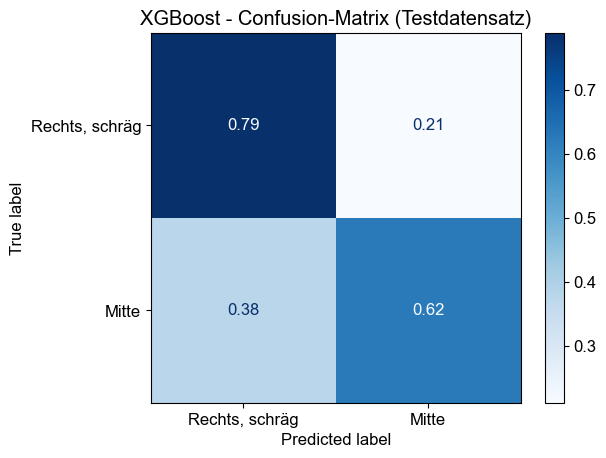

Confusion-Matrix für AdaBoost (Testdaten):
Confusion-Matrix für AdaBoost gespeichert unter: results/Probenposition//process_features/AdaBoost/final_confusion_matrix.svg


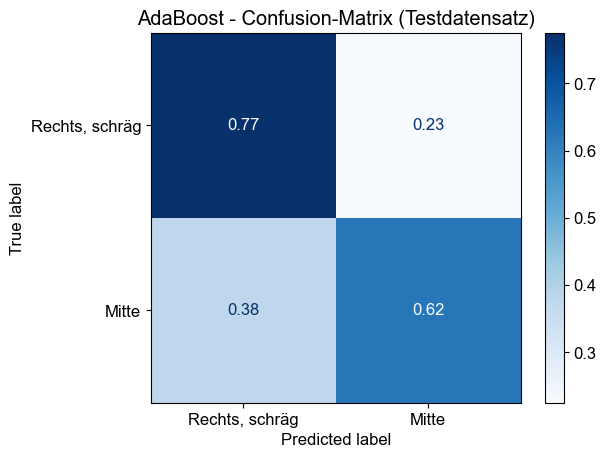

Confusion-Matrix für Random Forest (Testdaten):
Confusion-Matrix für Random Forest gespeichert unter: results/Probenposition//process_features/Random Forest/final_confusion_matrix.svg


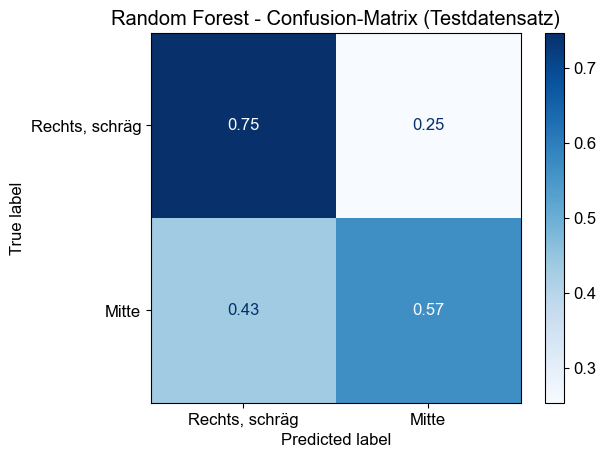

Confusion-Matrix für SVM (Testdaten):
Confusion-Matrix für SVM gespeichert unter: results/Probenposition//process_features/SVM/final_confusion_matrix.svg


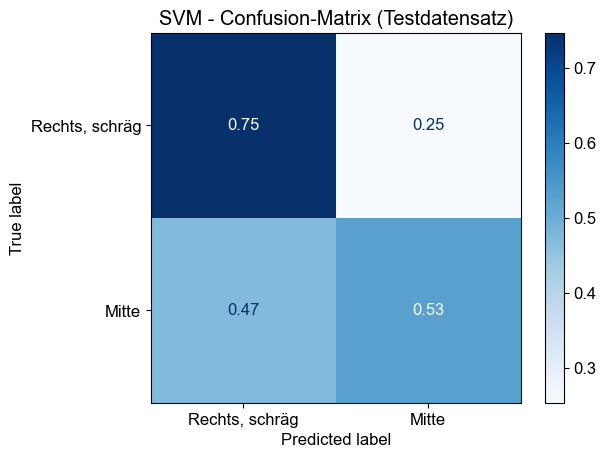

Confusion-Matrix für kNN (Testdaten):
Confusion-Matrix für kNN gespeichert unter: results/Probenposition//process_features/kNN/final_confusion_matrix.svg


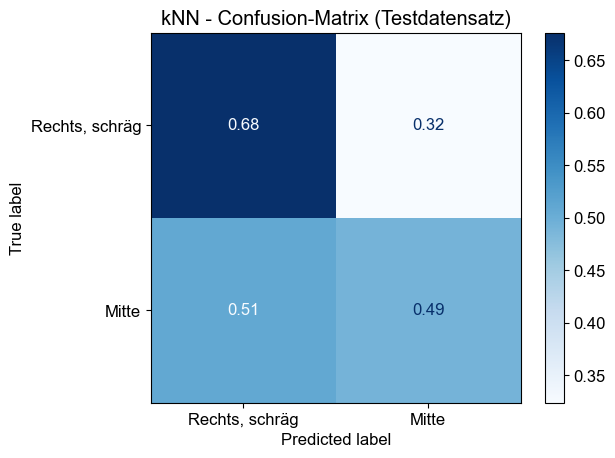

Confusion-Matrix für Logistische Regression (Testdaten):
Confusion-Matrix für Logistische Regression gespeichert unter: results/Probenposition//process_features/Logistische Regression/final_confusion_matrix.svg


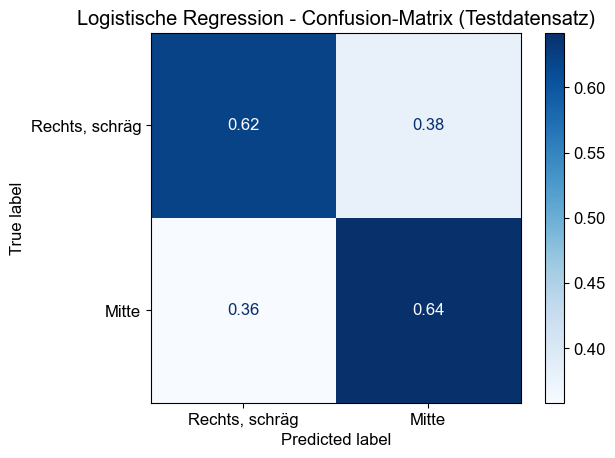

In [20]:
# Normalisierte durchschnittliche Confusion-Matrices anzeigen
display_final_confusion_matrices(
    confusion_matrices1,
    label_mapping_path=label_mapping_path,
    target_column=target_column,  # Zielspalte hinzufügen
    target_dir=target_dir,
    save_plots=save_plots,
    normalize=True,  # Optional
    Verkippung=Verkippung
)

## Overfitting Test

In diesem Abschnitt wird die Überprüfung von Overfitting durch die Analyse von Learning Curves und Validation Curves durchgeführt, um den Bias-Variance-Tradeoff besser zu verstehen. Die `analyze_model_performance` Funktion aus der `model_pipelines.py` führt diese Analysen durch und erstellt entsprechende Plots. Es werden sowohl die Trainingsscores als auch die Testscores über verschiedene Größen des Trainingssets und Hyperparameterbereiche betrachtet, um die Modellstabilität und die Generalisierungsfähigkeit zu bewerten. Dies hilft dabei, die optimale Komplexität der Modelle zu bestimmen und sicherzustellen, dass sie gut auf unbekannte Daten generalisieren.


Learning Curve Analyse für Probenposition:
Analysiere Modell: XGBoost...
Erstelle Validation Curve für XGBoost...
Validation Curve gespeichert unter: results/Probenposition//process_features/XGBoost/validation_curve_XGBoost_clf__n_estimators.svg


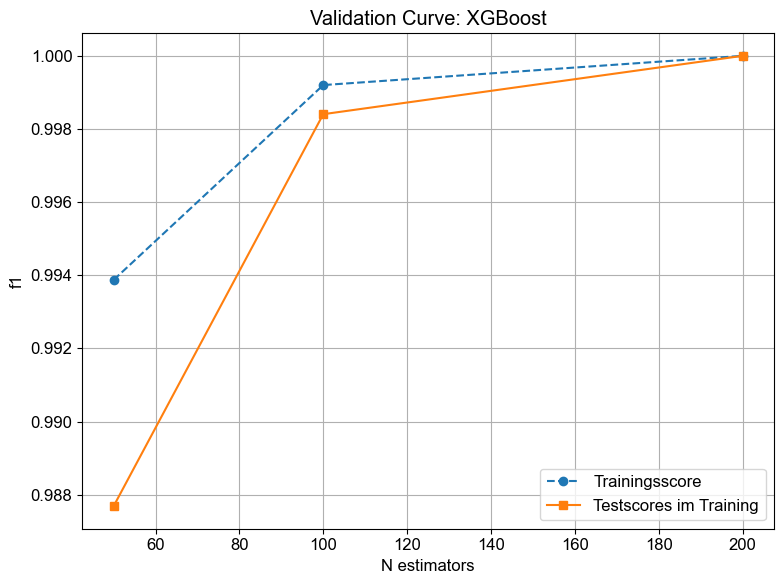

Erstelle Learning Curve für XGBoost...
Learning Curve gespeichert unter: results/Probenposition//process_features/XGBoost/learning_curve_XGBoost.svg


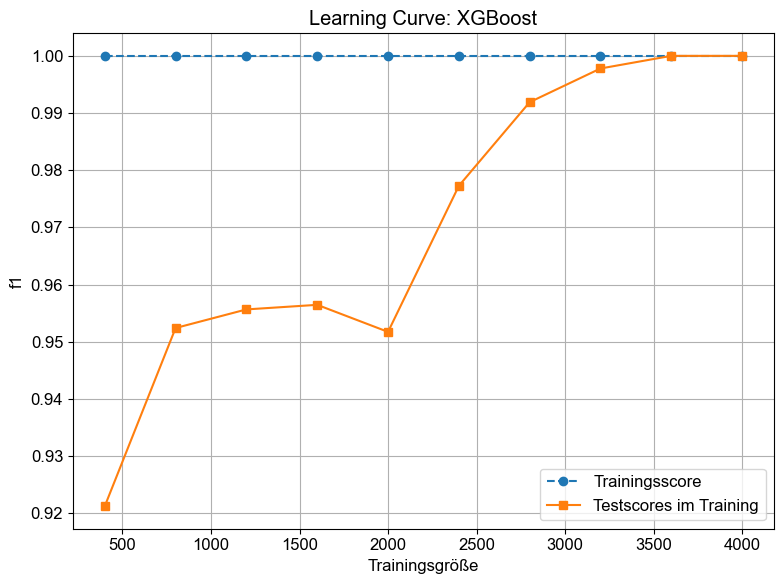

Analysiere Modell: AdaBoost...
Erstelle Validation Curve für AdaBoost...
Validation Curve gespeichert unter: results/Probenposition//process_features/AdaBoost/validation_curve_AdaBoost_clf__n_estimators.svg


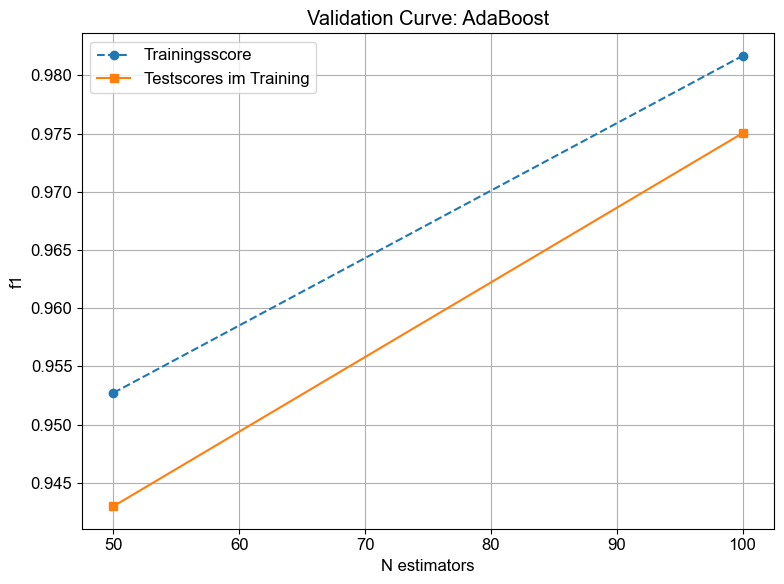

Erstelle Learning Curve für AdaBoost...
Learning Curve gespeichert unter: results/Probenposition//process_features/AdaBoost/learning_curve_AdaBoost.svg


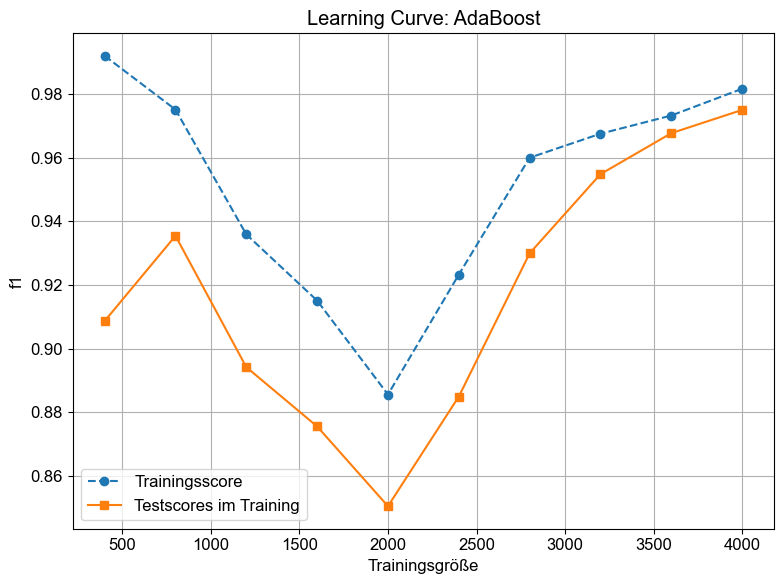

Analysiere Modell: Random Forest...
Erstelle Validation Curve für Random Forest...
Validation Curve gespeichert unter: results/Probenposition//process_features/Random Forest/validation_curve_Random Forest_clf__n_estimators.svg


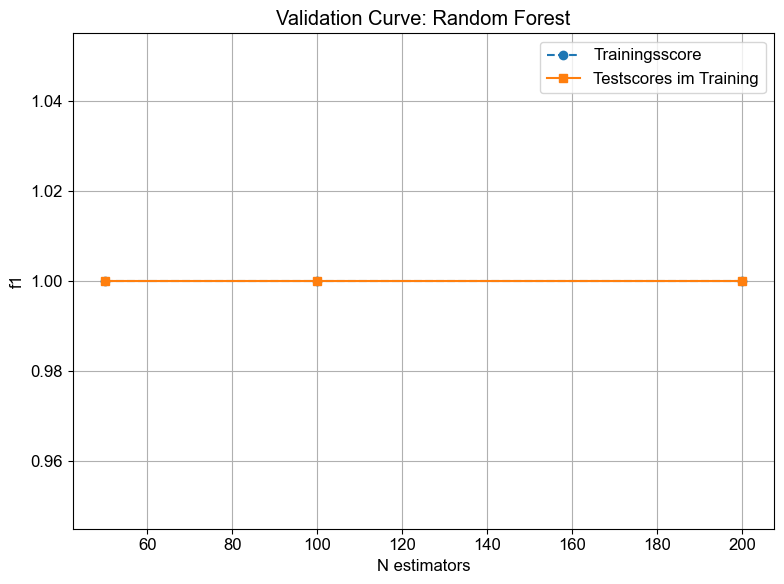

Erstelle Learning Curve für Random Forest...
Learning Curve gespeichert unter: results/Probenposition//process_features/Random Forest/learning_curve_Random Forest.svg


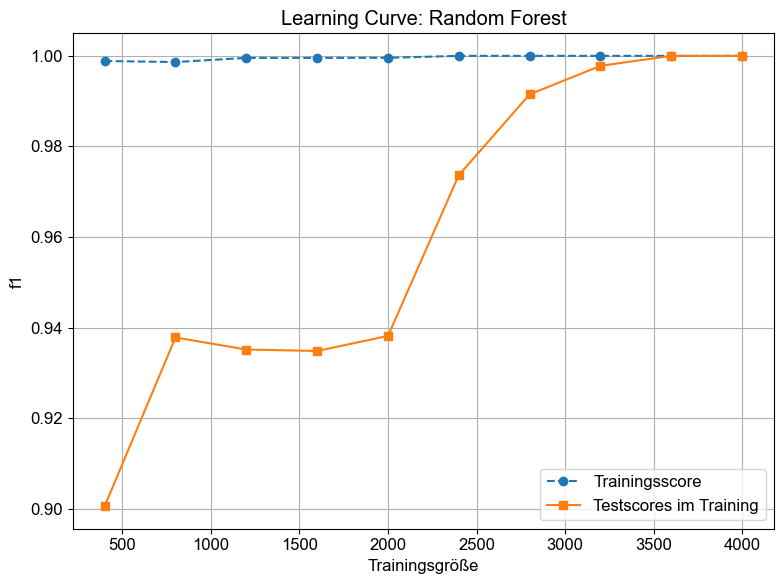

Analysiere Modell: SVM...
Erstelle Validation Curve für SVM...
Validation Curve gespeichert unter: results/Probenposition//process_features/SVM/validation_curve_SVM_clf__C.svg


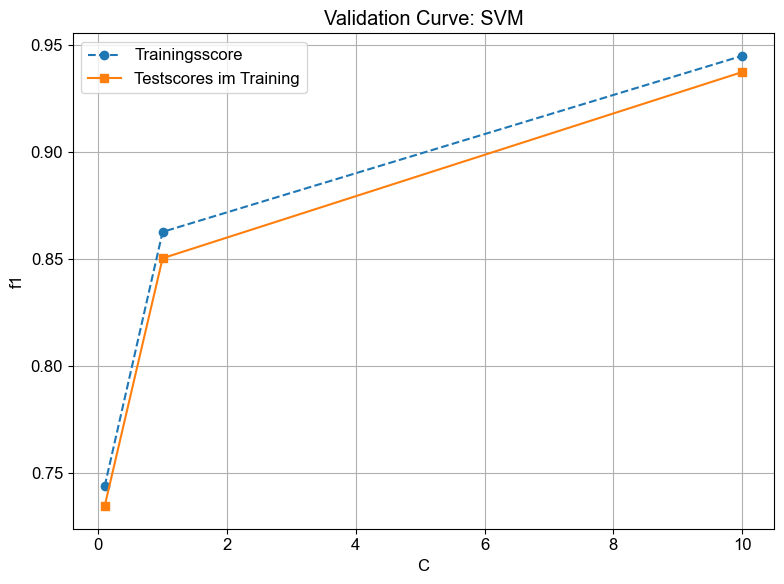

Erstelle Learning Curve für SVM...
Learning Curve gespeichert unter: results/Probenposition//process_features/SVM/learning_curve_SVM.svg


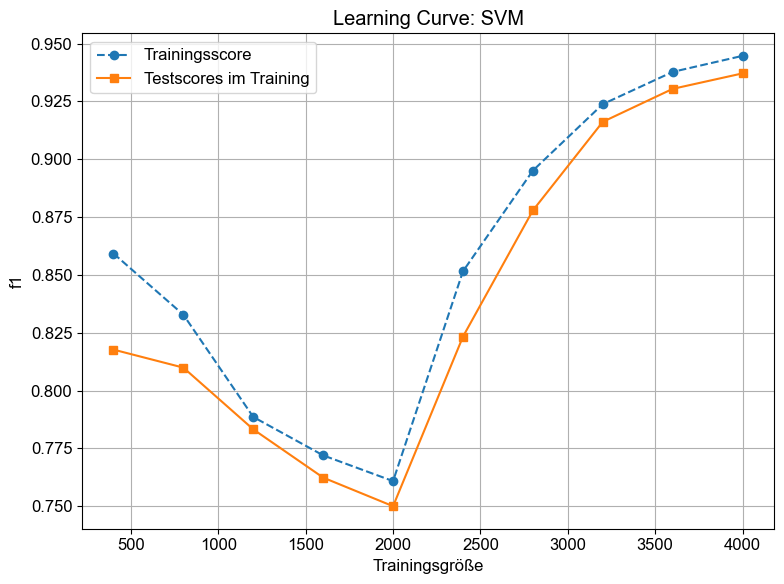

Analysiere Modell: kNN...
Erstelle Validation Curve für kNN...
Validation Curve gespeichert unter: results/Probenposition//process_features/kNN/validation_curve_kNN_clf__n_neighbors.svg


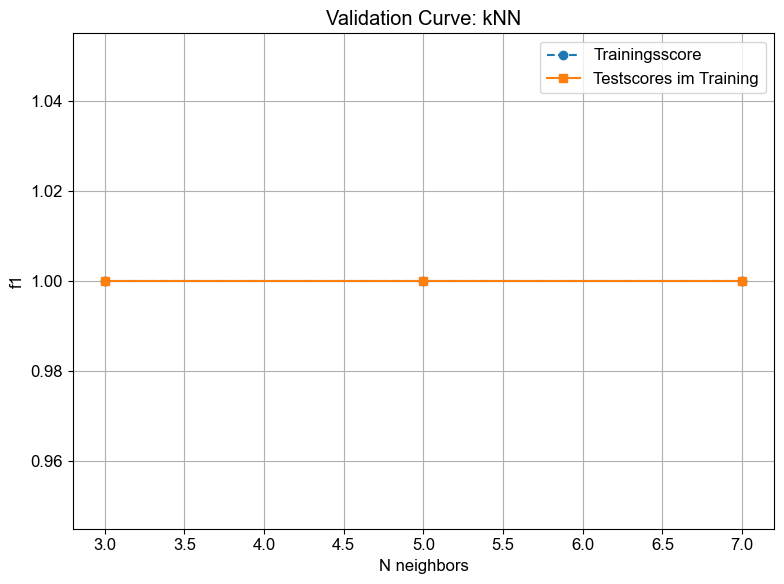

Erstelle Learning Curve für kNN...
Learning Curve gespeichert unter: results/Probenposition//process_features/kNN/learning_curve_kNN.svg


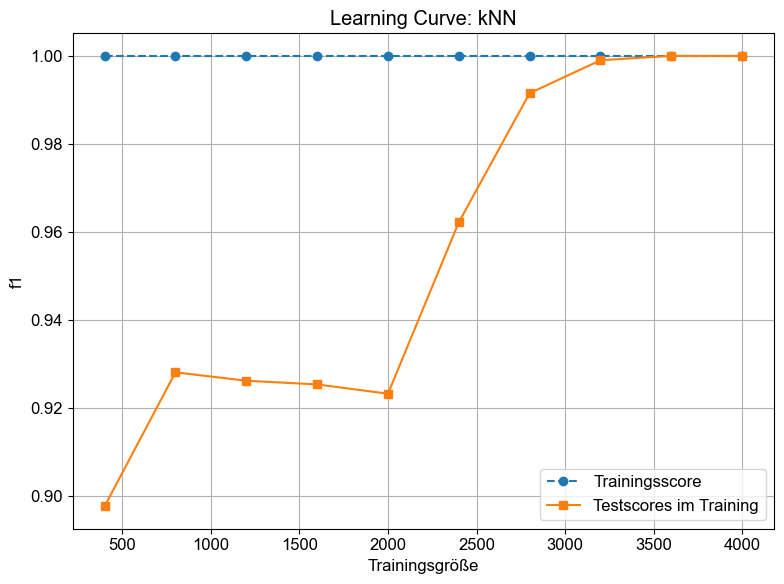

Analysiere Modell: Logistische Regression...
Erstelle Validation Curve für Logistische Regression...
Validation Curve gespeichert unter: results/Probenposition//process_features/Logistische Regression/validation_curve_Logistische Regression_clf__C.svg


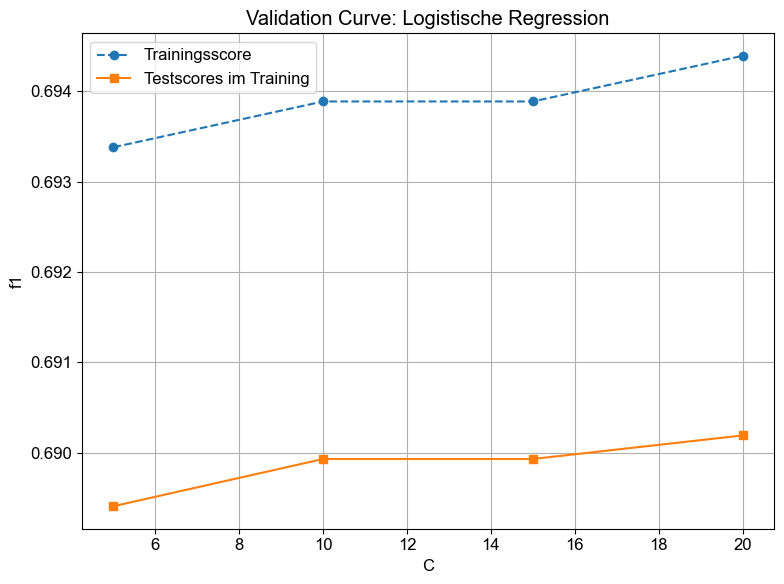

Erstelle Learning Curve für Logistische Regression...
Learning Curve gespeichert unter: results/Probenposition//process_features/Logistische Regression/learning_curve_Logistische Regression.svg


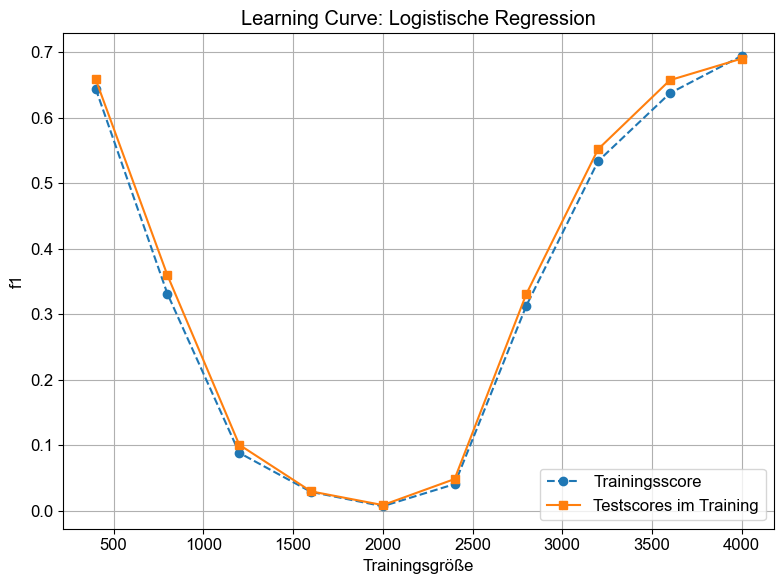

In [21]:
# Overfitting überprüfen 
# Analyse von Learning Curves für Bias-Variance-Tradeoff
print(f"\nLearning Curve Analyse für {target_name}:")

# Analyse der Modellleistung
analyze_model_performance(
    pipelines=pipelines, 
    param_grids=param_grids, 
    X=X_train, 
    y=y_train, 
    scoring='f1', 
    cv=skf,
    save_plots=save_plots,
    output_dir= target_dir,
    Verkippung=Verkippung
)


## SHAP-Analyse

In diesem Abschnitt führen wir eine SHAP-Analyse durch, um die Einflüsse der einzelnen Features auf die Vorhersagen der besten Modelle zu verstehen. Die Ergebnisse dieser Analyse helfen uns, die Modellentscheidungen transparenter zu machen. Anschließend laden wir Diagramme, die die besten drei Modelle basierend auf unterschiedlichen Metriken darstellen. Diese Visualisierungen unterstützen die Bewertung der Modellperformance und die Identifizierung von Schlüsselfeatures, die die Zielgröße beeinflussen.

In [22]:
# SHAP-Analyse
if shap_on:
    shap_analysis(
    best_pipelines=best_pipelines,  # Das Dictionary der besten Pipelines
    X_train=X_train,  # Die Trainingsdaten
    target_name = target_name,  # Der Zielname, z. B. für das Modellieren des Zielwerts
    dataset_name= dataset_name,  # Der Name des Datensets
    output_dir= target_dir,  # Optional: Basisverzeichnis für die Ergebnisse
    plot_type=plot_type,
    save_plots=save_plots,  # Angabe, ob die Diagramme gespeichert werden sollen
    verkippung = Verkippung
)


In [23]:
# Alle Diagramme aus der Zielgröße laden
display_top_models_for_target(
    target_dir,
    results_df_1,
    metric,
    verkippung=Verkippung,
    top_n=3  # Nur die besten 3 Modelle anzeigen
)


Top-3 Modelle basierend auf der Metrik 'f1_weighted':
XGBoost          0.715556
AdaBoost         0.707962
Random Forest    0.666794
Name: f1_weighted, dtype: object

Top-3 Modelle basierend auf der gewichteten Metrik 'f1_weighted':
XGBoost          0.715556
AdaBoost         0.707962
Random Forest    0.666794
Name: f1_weighted, dtype: object

Top-3 Modelle basierend auf der gewichteten Metrik 'percent_diff_f1_weighted':
kNN              40.560855
Random Forest    33.320623
SVM              31.368755
Name: percent_diff_f1_weighted, dtype: object

Anzeigen der SHAP-Diagramme für Modelle in den Top-3 (zusammengefasst): Random Forest, AdaBoost, kNN, XGBoost, SVM
SHAP-Diagramm für Random Forest nicht gefunden unter results/Probenposition//process_features/Random Forest/shap_summary_Random Forest.svg.
SHAP-Diagramm für AdaBoost nicht gefunden unter results/Probenposition//process_features/AdaBoost/shap_summary_AdaBoost.svg.
SHAP-Diagramm für kNN nicht gefunden unter results/Probenposition//p

In [24]:
# if shap_on:
#     feature_importances, irrelevant_features = extract_feature_importance_from_shap(
#         best_pipelines=best_pipelines,
#         X_train=X_train,
#         target_name=target_name,
#         dataset_name=dataset_name,
#         output_dir=target_dir,
#         verkippung=Verkippung,
#         importance_threshold=0.01,
#         save_results=save_plots
#     )

#     # Ausgabe der irrelevanten Features
#     print("Irrelevante Features:", irrelevant_features)

# Aggregierte Daten

In [25]:
# Einstellungen
dataset_name = "aggregated_features"

target_dir, feature_importance_path, balance_suffix, feature_importance_path_best, target_dir_best, tilt_suffix, temp_suffix = direcetion_results(dataset_name, target_name, smote_on, Verkippung, bauteil_temp)

# Auswahl der Process Features aus dem Dataset
columns_aggregated_features = [
    "VersuchID",
    "Berührzeit",
    "Höhe_Wegmessung_Aufprall",
    "Umformzeit",
    "Tiefster_Punkt",
    "Energie_Aufprall",
    "Motorstrom_Durchschnitt",
    "Energie_ab_Durchschnitt",
    "Bauteil_Temp",
    "Werkzeug_Temp",
    "Material_con",
    "Position_con",
    "Ergebnis_con",
    "Probenhoehe",
    "richtig_verbaut",
    "Wegmessung_Min",
    "Wegmessung_Max",
    "Wegmessung_Mean",
    "Wegmessung_Median",
    "Wegmessung_Std",
    "Verkippung_1_Min",
    "Verkippung_1_Max",
    "Verkippung_1_Mean",
    "Verkippung_1_Median",
    "Verkippung_1_Std",
    "Verkippung_2_Min",
    "Verkippung_2_Max",
    "Verkippung_2_Mean",
    "Verkippung_2_Median",
    "Verkippung_2_Std",
    "Verkippung_3_Min",
    "Verkippung_3_Max",
    "Verkippung_3_Mean",
    "Verkippung_3_Median",
    "Verkippung_3_Std",
    "Verkippung_4_Min",
    "Verkippung_4_Max",
    "Verkippung_4_Mean",
    "Verkippung_4_Median",
    "Verkippung_4_Std",
    "Stoesselhub_Min",
    "Stoesselhub_Max",
    "Stoesselhub_Mean",
    "Stoesselhub_Median",
    "Stoesselhub_Std",
    "Geschwindigkeit_Ges_Min",
    "Geschwindigkeit_Ges_Max",
    "Geschwindigkeit_Ges_Mean",
    "Geschwindigkeit_Ges_Median",
    "Geschwindigkeit_Ges_Std",
    "Presskraft_dyn_Min",
    "Presskraft_dyn_Max",
    "Presskraft_dyn_Mean",
    "Presskraft_dyn_Median",
    "Presskraft_dyn_Std",
    "Motorstrom_Min",
    "Motorstrom_Max",
    "Motorstrom_Mean",
    "Motorstrom_Median",
    "Motorstrom_Std",
]

# Sicherstellen, dass nur existierende Spalten verwendet werden
columns_to_keep_train = [col for col in columns_aggregated_features if col in X_train_original.columns]

# X_train und X_test auf relevante Spalten beschränken
X_train = X_train_original[columns_to_keep_train]
X_test = X_test_original[columns_to_keep_train]

# Falls Fehler auftreten, können wir sicherstellen, dass alle Spalten korrekt bereinigt sind:
X_train.columns = X_train.columns.str.strip()  # Entferne führende und nachfolgende Leerzeichen
X_test.columns = X_test.columns.str.strip()

print("Bereinigte Spalten in X_train:", X_train.columns)
print("Bereinigte Spalten in X_test:", X_test.columns)
print(len(X_train.columns))

Bereinigte Spalten in X_train: Index(['Berührzeit', 'Höhe_Wegmessung_Aufprall', 'Umformzeit',
       'Tiefster_Punkt', 'Energie_Aufprall', 'Motorstrom_Durchschnitt',
       'Energie_ab_Durchschnitt', 'Bauteil_Temp', 'Werkzeug_Temp',
       'Wegmessung_Min', 'Wegmessung_Max', 'Wegmessung_Mean',
       'Wegmessung_Median', 'Wegmessung_Std', 'Verkippung_1_Min',
       'Verkippung_1_Max', 'Verkippung_1_Mean', 'Verkippung_1_Median',
       'Verkippung_1_Std', 'Verkippung_2_Min', 'Verkippung_2_Max',
       'Verkippung_2_Mean', 'Verkippung_2_Median', 'Verkippung_2_Std',
       'Verkippung_3_Min', 'Verkippung_3_Max', 'Verkippung_3_Mean',
       'Verkippung_3_Median', 'Verkippung_3_Std', 'Verkippung_4_Min',
       'Verkippung_4_Max', 'Verkippung_4_Mean', 'Verkippung_4_Median',
       'Verkippung_4_Std', 'Stoesselhub_Min', 'Stoesselhub_Max',
       'Stoesselhub_Mean', 'Stoesselhub_Median', 'Stoesselhub_Std',
       'Geschwindigkeit_Ges_Min', 'Geschwindigkeit_Ges_Max',
       'Geschwindigkeit_Ges

## Training

In [26]:
# Modelltraining und Bewertung
best_pipelines, results, confusion_matrices2 = train_and_tune_models_balanced(pipelines, 
    param_grids, 
    X_train, 
    y_train, 
    skf, 
    X_test=X_test, 
    y_test=y_test
)

# Ergebnisse in DataFrame speichern
results_df_2 = pd.DataFrame.from_dict(results, orient='index').T
#results_df.drop(['best_params'], axis=0, inplace=True)

# Ergebnisse in tabellarischer Form anzeigen
display(HTML(results_df_2.to_html()))

save_scores_to_csv(
    results=results_df_2,  # DataFrame mit den Scores
    output_dir=target_dir,
    file_name=f"model_scores_{dataset_name}{balance_suffix}.csv",  # Gemeinsamer Basisname
    Verkippung=Verkippung  # Fügt den '_no_tilt'-Suffix hinzu, falls nötig
)

Training XGBoost...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Berechnung der finalen Scores für XGBoost...
Training AdaBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Berechnung der finalen Scores für AdaBoost...
Training Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


KeyboardInterrupt: 

## Confusion Matrices

Confusion-Matrix für XGBoost (Testdaten):
Confusion-Matrix für XGBoost gespeichert unter: results/Probenposition//aggregated_features/XGBoost/final_confusion_matrix.svg


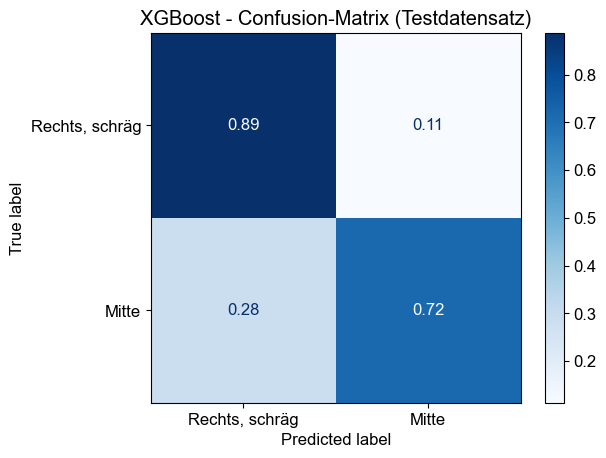

Confusion-Matrix für AdaBoost (Testdaten):
Confusion-Matrix für AdaBoost gespeichert unter: results/Probenposition//aggregated_features/AdaBoost/final_confusion_matrix.svg


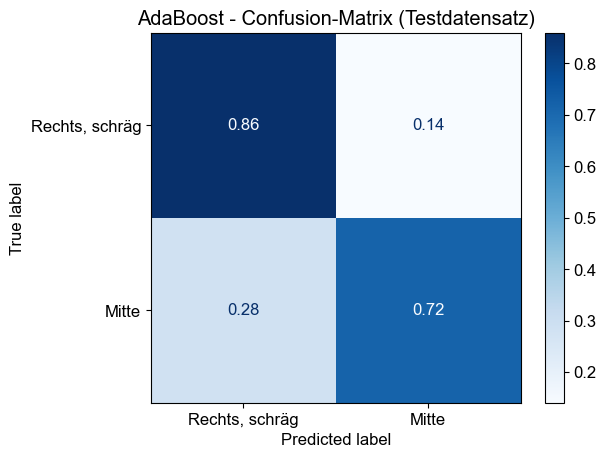

Confusion-Matrix für Random Forest (Testdaten):
Confusion-Matrix für Random Forest gespeichert unter: results/Probenposition//aggregated_features/Random Forest/final_confusion_matrix.svg


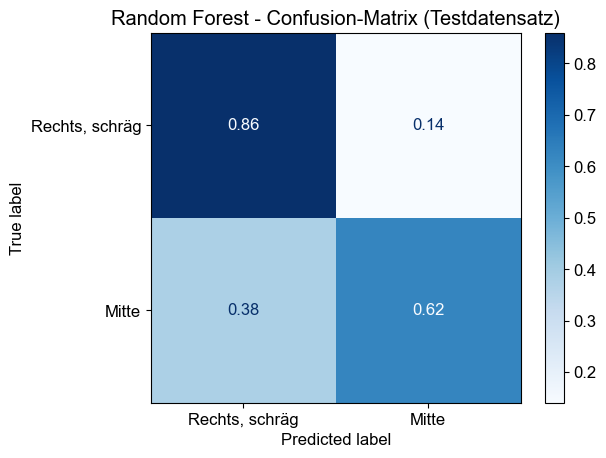

Confusion-Matrix für SVM (Testdaten):
Confusion-Matrix für SVM gespeichert unter: results/Probenposition//aggregated_features/SVM/final_confusion_matrix.svg


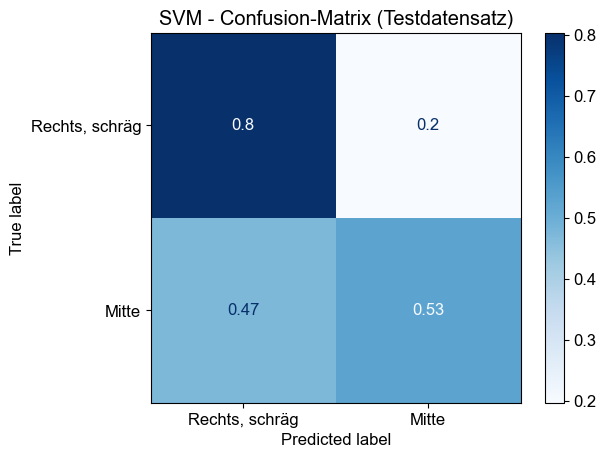

Confusion-Matrix für kNN (Testdaten):
Confusion-Matrix für kNN gespeichert unter: results/Probenposition//aggregated_features/kNN/final_confusion_matrix.svg


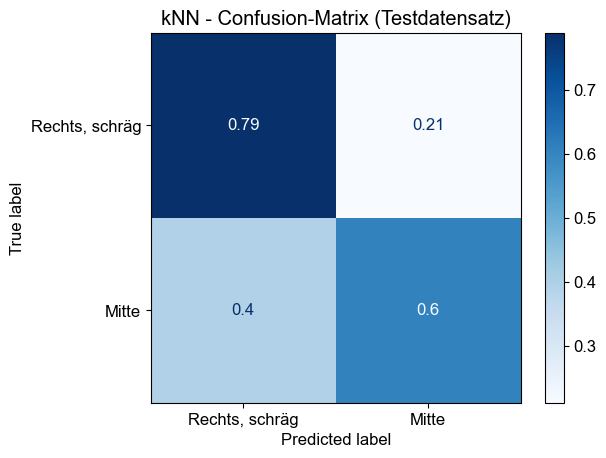

Confusion-Matrix für Logistische Regression (Testdaten):
Confusion-Matrix für Logistische Regression gespeichert unter: results/Probenposition//aggregated_features/Logistische Regression/final_confusion_matrix.svg


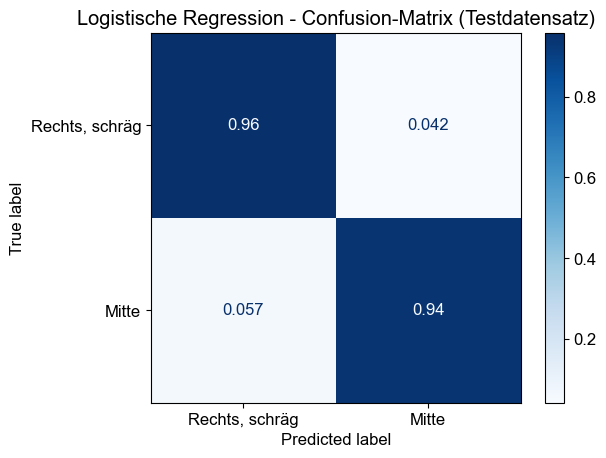

In [ ]:
# Normalisierte durchschnittliche Confusion-Matrices anzeigen
display_final_confusion_matrices(
    confusion_matrices2,
    label_mapping_path=label_mapping_path,
    target_column=target_column,  # Zielspalte hinzufügen
    target_dir=target_dir,
    save_plots=save_plots,
    normalize=True,  # Optional
    Verkippung=Verkippung
)

## Overfitting Test


Learning Curve Analyse für Probenposition:
Analysiere Modell: XGBoost...
Erstelle Validation Curve für XGBoost...
Validation Curve gespeichert unter: results/Probenposition//aggregated_features/XGBoost/validation_curve_XGBoost_clf__n_estimators.svg


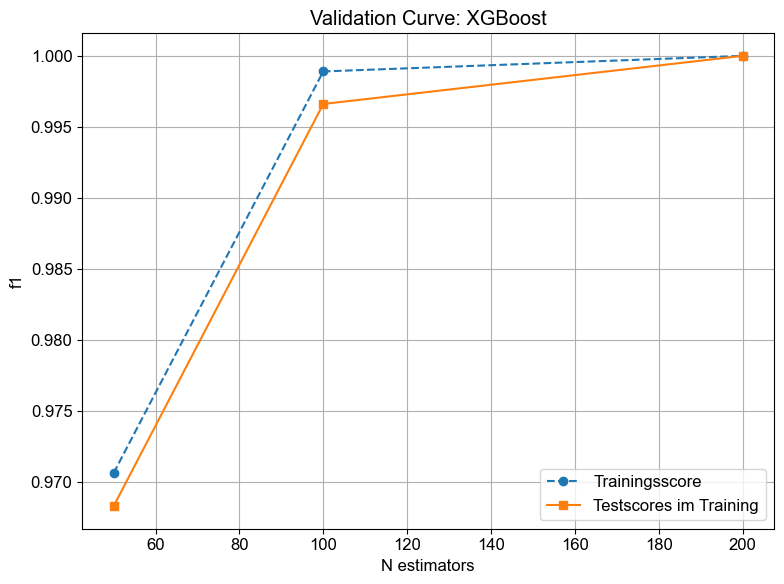

Erstelle Learning Curve für XGBoost...
Learning Curve gespeichert unter: results/Probenposition//aggregated_features/XGBoost/learning_curve_XGBoost.svg


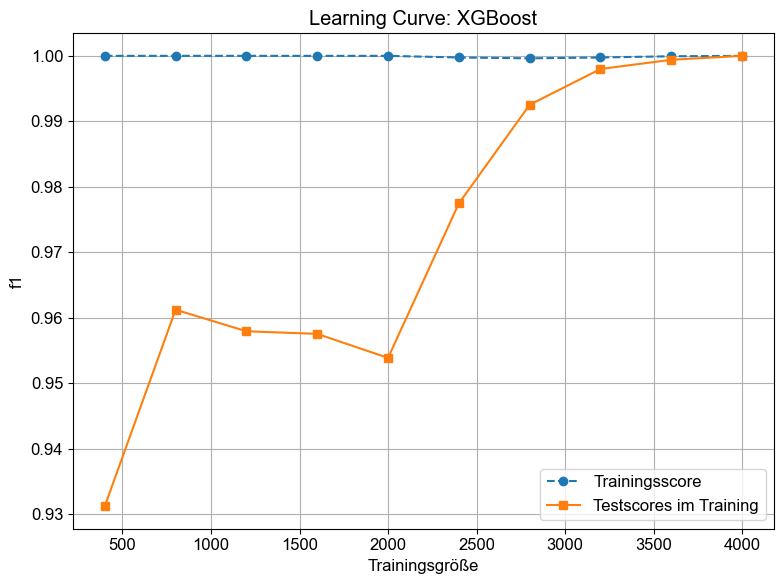

Analysiere Modell: AdaBoost...
Erstelle Validation Curve für AdaBoost...
Validation Curve gespeichert unter: results/Probenposition//aggregated_features/AdaBoost/validation_curve_AdaBoost_clf__n_estimators.svg


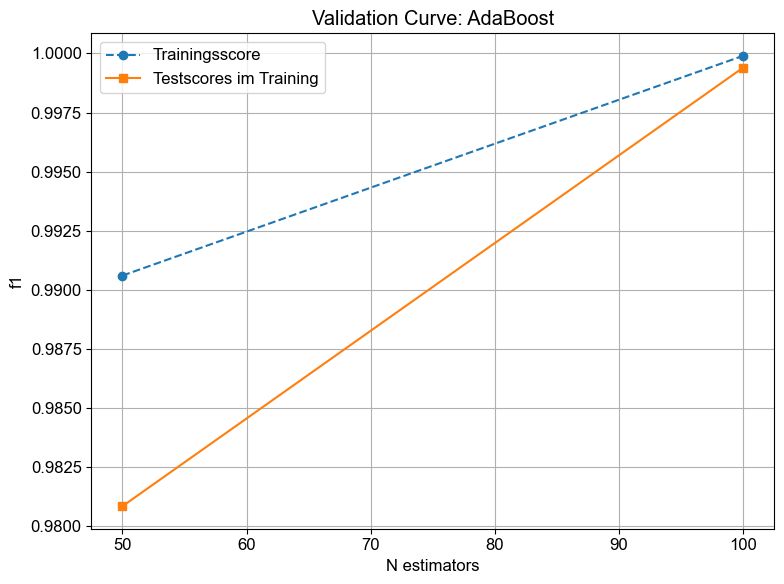

Erstelle Learning Curve für AdaBoost...
Learning Curve gespeichert unter: results/Probenposition//aggregated_features/AdaBoost/learning_curve_AdaBoost.svg


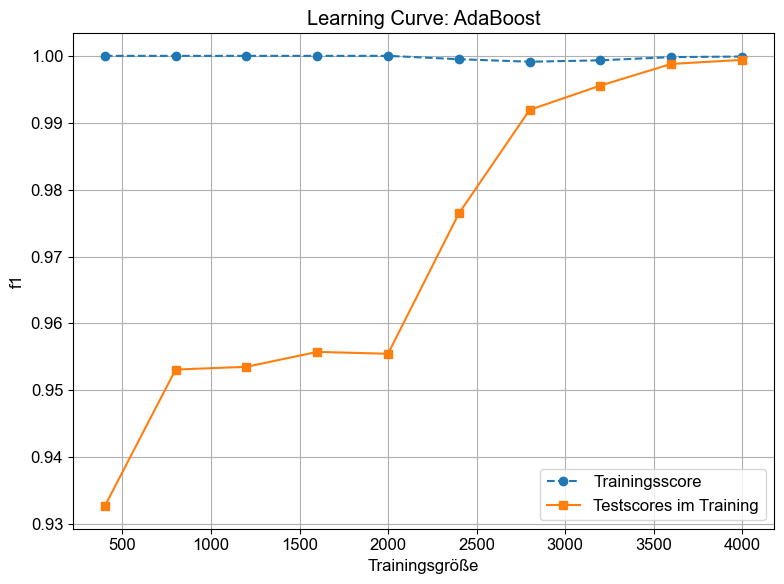

Analysiere Modell: Random Forest...
Erstelle Validation Curve für Random Forest...
Validation Curve gespeichert unter: results/Probenposition//aggregated_features/Random Forest/validation_curve_Random Forest_clf__n_estimators.svg


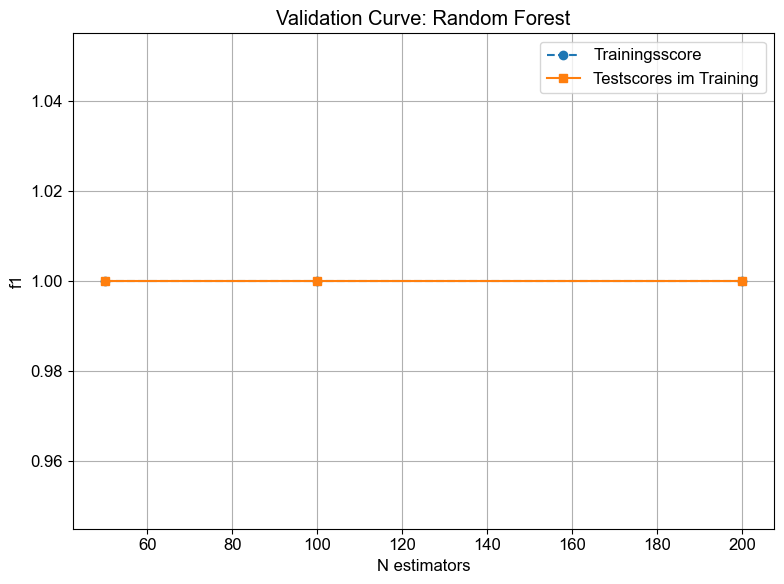

Erstelle Learning Curve für Random Forest...
Learning Curve gespeichert unter: results/Probenposition//aggregated_features/Random Forest/learning_curve_Random Forest.svg


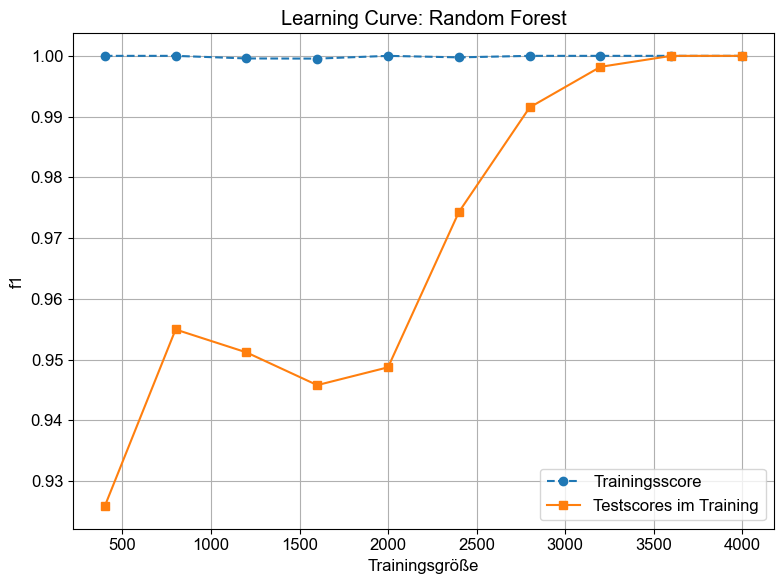

Analysiere Modell: SVM...
Erstelle Validation Curve für SVM...
Validation Curve gespeichert unter: results/Probenposition//aggregated_features/SVM/validation_curve_SVM_clf__C.svg


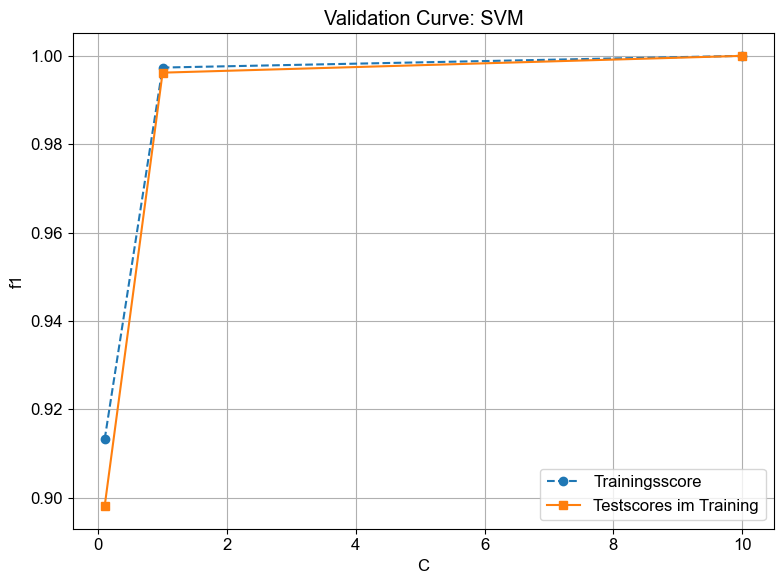

Erstelle Learning Curve für SVM...
Learning Curve gespeichert unter: results/Probenposition//aggregated_features/SVM/learning_curve_SVM.svg


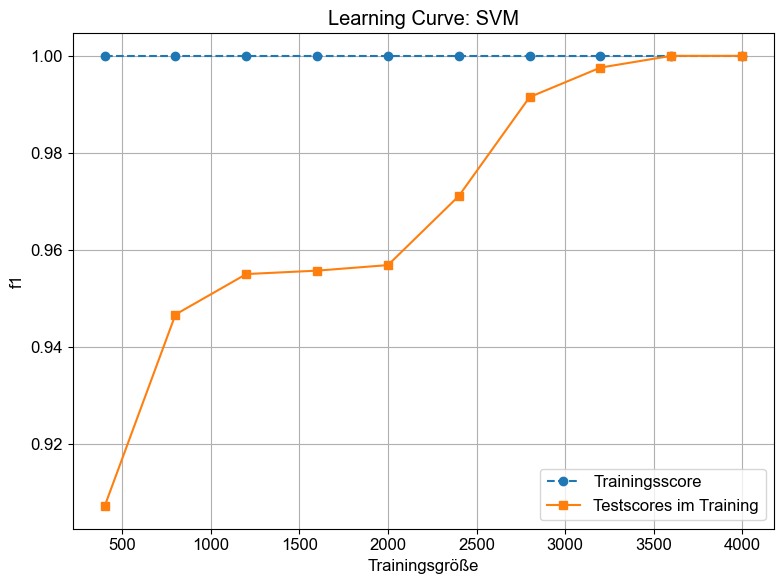

Analysiere Modell: kNN...
Erstelle Validation Curve für kNN...
Validation Curve gespeichert unter: results/Probenposition//aggregated_features/kNN/validation_curve_kNN_clf__n_neighbors.svg


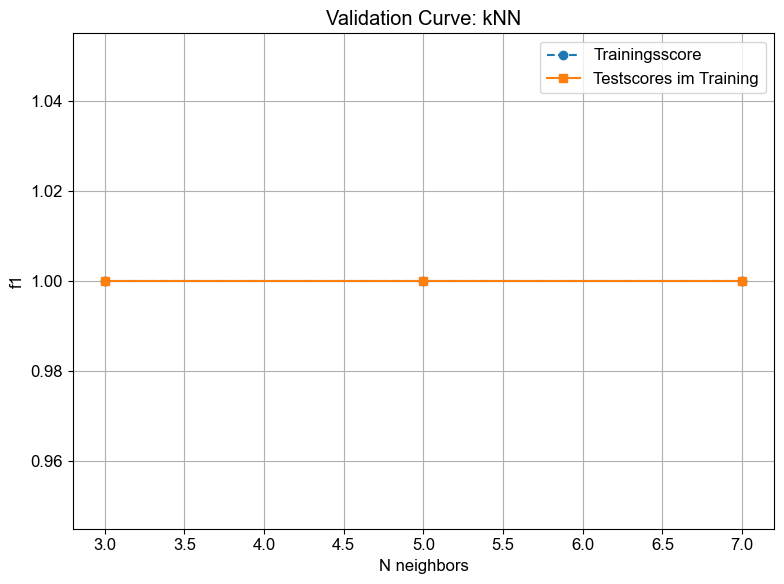

Erstelle Learning Curve für kNN...
Learning Curve gespeichert unter: results/Probenposition//aggregated_features/kNN/learning_curve_kNN.svg


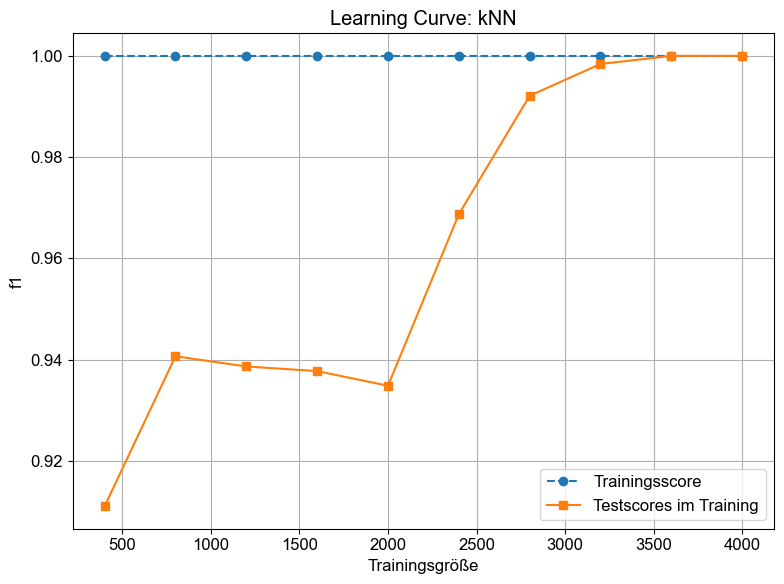

Analysiere Modell: Logistische Regression...
Erstelle Validation Curve für Logistische Regression...


/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn

Validation Curve gespeichert unter: results/Probenposition//aggregated_features/Logistische Regression/validation_curve_Logistische Regression_clf__C.svg


/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


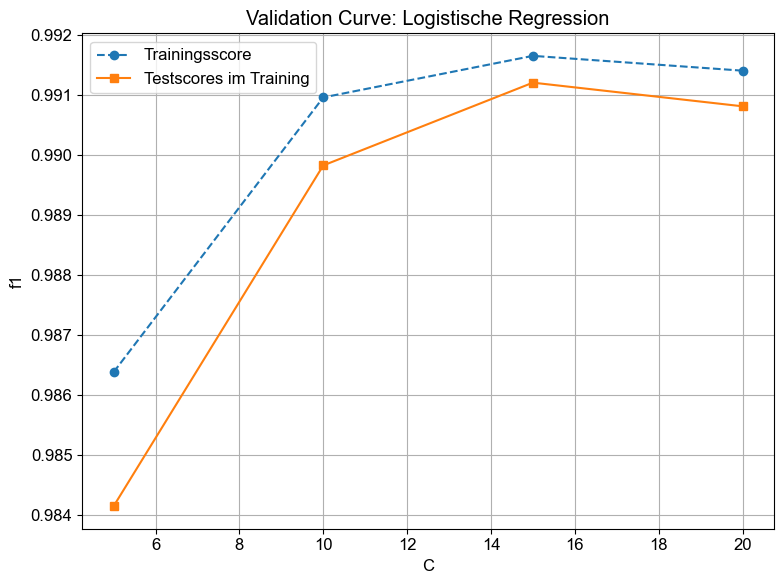

Erstelle Learning Curve für Logistische Regression...


/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn

Learning Curve gespeichert unter: results/Probenposition//aggregated_features/Logistische Regression/learning_curve_Logistische Regression.svg


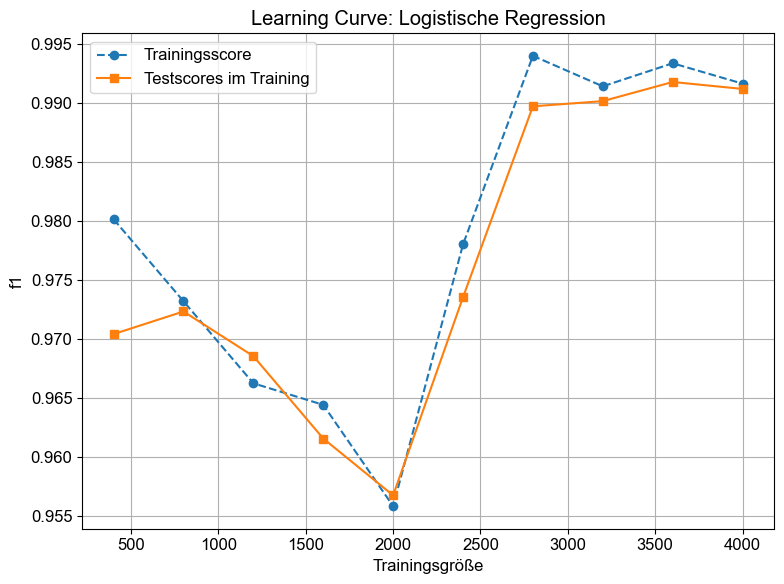

In [ ]:
# Overfitting überprüfen 
# Analyse von Learning Curves für Bias-Variance-Tradeoff
print(f"\nLearning Curve Analyse für {target_name}:")

# Analyse der Modellleistung
analyze_model_performance(
    pipelines=pipelines, 
    param_grids=param_grids, 
    X=X_train, 
    y=y_train, 
    scoring='f1', 
    cv=skf,
    save_plots=save_plots,
    output_dir= target_dir,
    Verkippung=Verkippung
)

## SHAP-Analyse

In [ ]:
# SHAP-Analyse
if shap_on:
    shap_analysis(
    best_pipelines=best_pipelines,  # Das Dictionary der besten Pipelines
    X_train=X_train,  # Die Trainingsdaten
    target_name = target_name,  # Der Zielname, z. B. für das Modellieren des Zielwerts
    dataset_name= dataset_name,  # Der Name des Datensets
    output_dir= target_dir,  # Optional: Basisverzeichnis für die Ergebnisse
    plot_type=plot_type,
    save_plots=save_plots,  # Angabe, ob die Diagramme gespeichert werden sollen
    verkippung = Verkippung
)
    #starting_shap

In [ ]:
# Alle Diagramme aus der Zielgröße laden
display_top_models_for_target(
    target_dir,
    results_df_2,
    metric,
    verkippung=Verkippung,
    top_n=3  # Nur die besten 3 Modelle anzeigen
)


Top-3 Modelle basierend auf der Metrik 'f1_weighted':
Logistische Regression    0.951613
XGBoost                   0.812316
AdaBoost                  0.796825
Name: f1_weighted, dtype: object

Top-3 Modelle basierend auf der gewichteten Metrik 'f1_weighted':
Logistische Regression    0.951613
XGBoost                   0.812316
AdaBoost                  0.796825
Name: f1_weighted, dtype: object

Top-3 Modelle basierend auf der gewichteten Metrik 'percent_diff_f1_weighted':
SVM              32.141882
kNN              29.314734
Random Forest    24.657789
Name: percent_diff_f1_weighted, dtype: object

Anzeigen der SHAP-Diagramme für Modelle in den Top-3 (zusammengefasst): Random Forest, Logistische Regression, XGBoost, kNN, SVM, AdaBoost
SHAP-Diagramm für Random Forest nicht gefunden unter results/Probenposition//aggregated_features/Random Forest/shap_summary_Random Forest.svg.
SHAP-Diagramm für Logistische Regression nicht gefunden unter results/Probenposition//aggregated_features/Logist

# New Features Dataset

In [27]:
# Einstellungen
dataset_name = "new_features"

target_dir, feature_importance_path, balance_suffix, feature_importance_path_best, target_dir_best, tilt_suffix, temp_suffix = direcetion_results(dataset_name, target_name, smote_on, Verkippung, bauteil_temp)

# X_train und X_test auf relevante Spalten beschränken
X_train = X_train_original
X_test = X_test_original

## Training

In [28]:
# Modelltraining und Bewertung
best_pipelines, results, confusion_matrices3 = train_and_tune_models_balanced(pipelines, 
    param_grids, 
    X_train, 
    y_train, 
    skf, 
    X_test=X_test, 
    y_test=y_test
)

# Ergebnisse in DataFrame speichern
results_df_3 = pd.DataFrame.from_dict(results, orient='index').T
#results_df.drop(['best_params'], axis=0, inplace=True)

# Ergebnisse in tabellarischer Form anzeigen
display(HTML(results_df_3.to_html()))

save_scores_to_csv(
    results=results_df_3,  # DataFrame mit den Scores
    output_dir=target_dir,
    file_name=f"model_scores_{dataset_name}{balance_suffix}.csv",  # Gemeinsamer Basisname
    Verkippung=Verkippung  # Fügt den '_no_tilt'-Suffix hinzu, falls nötig
)

Training XGBoost...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Berechnung der finalen Scores für XGBoost...
Training AdaBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Berechnung der finalen Scores für AdaBoost...
Training Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Berechnung der finalen Scores für Random Forest...
Training SVM...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Berechnung der finalen Scores für SVM...
Training kNN...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Berechnung der finalen Scores für kNN...
Training Logistische Regression...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/py

KeyboardInterrupt: 

## Confusion Matrices

Confusion-Matrix für XGBoost (Testdaten):
Confusion-Matrix für XGBoost gespeichert unter: results/Probenposition//new_features/XGBoost/final_confusion_matrix.svg


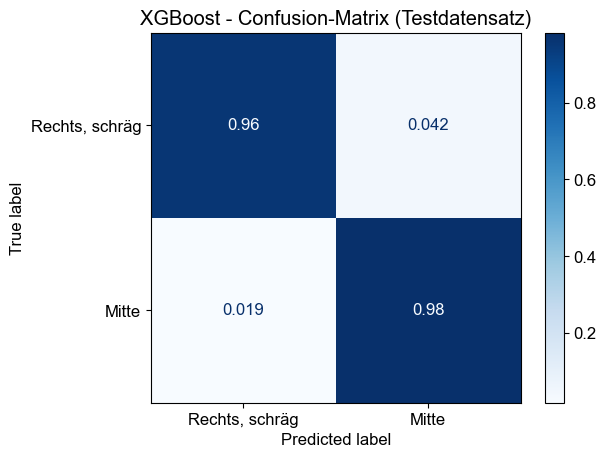

Confusion-Matrix für AdaBoost (Testdaten):
Confusion-Matrix für AdaBoost gespeichert unter: results/Probenposition//new_features/AdaBoost/final_confusion_matrix.svg


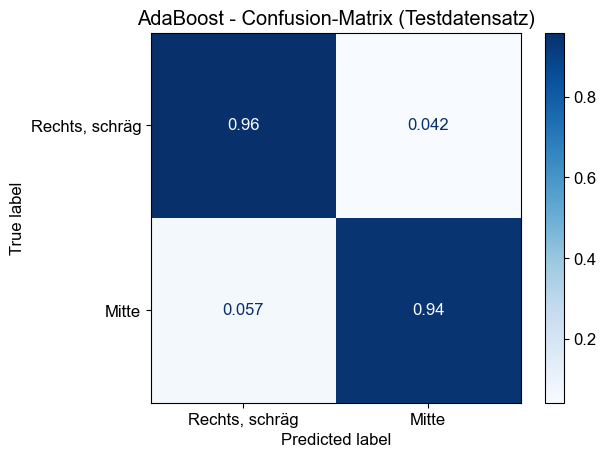

Confusion-Matrix für Random Forest (Testdaten):
Confusion-Matrix für Random Forest gespeichert unter: results/Probenposition//new_features/Random Forest/final_confusion_matrix.svg


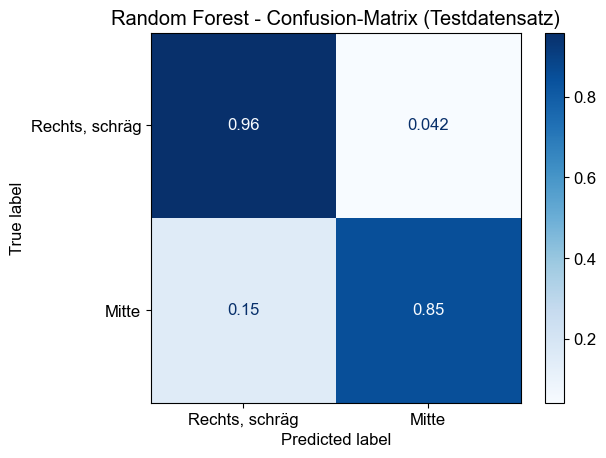

Confusion-Matrix für SVM (Testdaten):
Confusion-Matrix für SVM gespeichert unter: results/Probenposition//new_features/SVM/final_confusion_matrix.svg


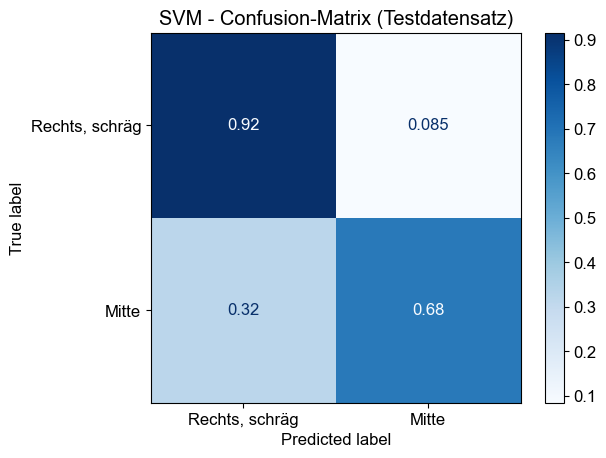

Confusion-Matrix für kNN (Testdaten):
Confusion-Matrix für kNN gespeichert unter: results/Probenposition//new_features/kNN/final_confusion_matrix.svg


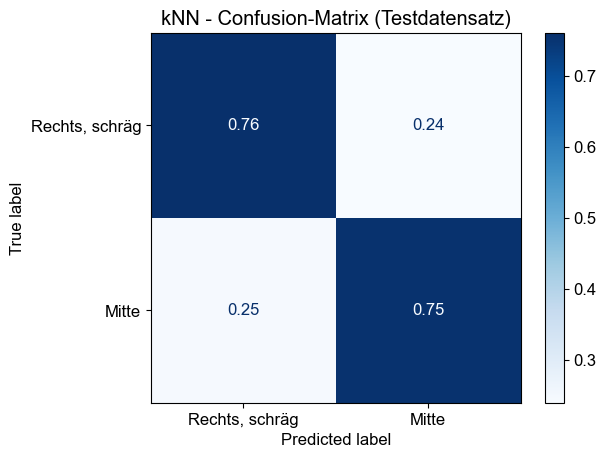

Confusion-Matrix für Logistische Regression (Testdaten):
Confusion-Matrix für Logistische Regression gespeichert unter: results/Probenposition//new_features/Logistische Regression/final_confusion_matrix.svg


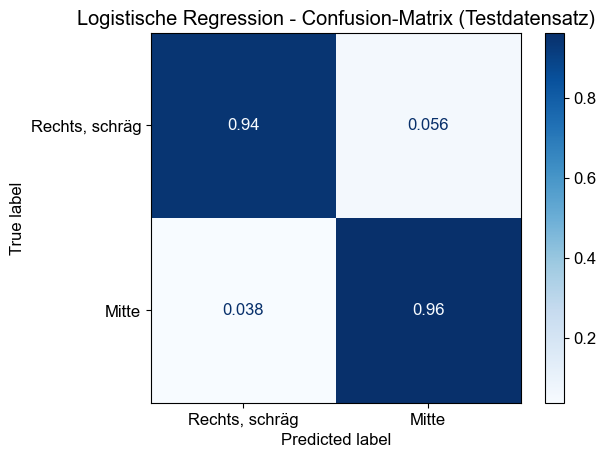

In [ ]:
# Normalisierte durchschnittliche Confusion-Matrices anzeigen
display_final_confusion_matrices(
    confusion_matrices3,
    label_mapping_path=label_mapping_path,
    target_column=target_column,  # Zielspalte hinzufügen
    target_dir=target_dir,
    save_plots=save_plots,
    normalize=True,  # Optional
    Verkippung=Verkippung
)

## Overfitting Test


Learning Curve Analyse für Probenposition:
Analysiere Modell: XGBoost...
Erstelle Validation Curve für XGBoost...
Validation Curve gespeichert unter: results/Probenposition//new_features/XGBoost/validation_curve_XGBoost_clf__n_estimators.svg


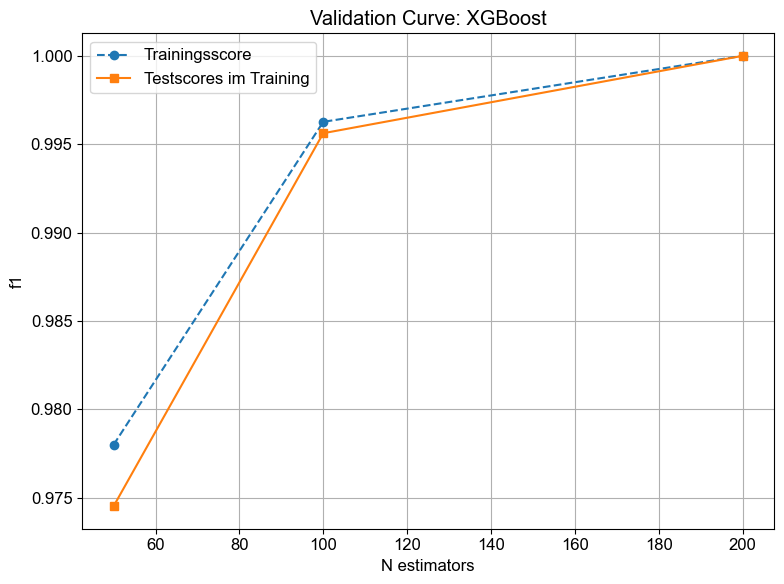

Erstelle Learning Curve für XGBoost...
Learning Curve gespeichert unter: results/Probenposition//new_features/XGBoost/learning_curve_XGBoost.svg


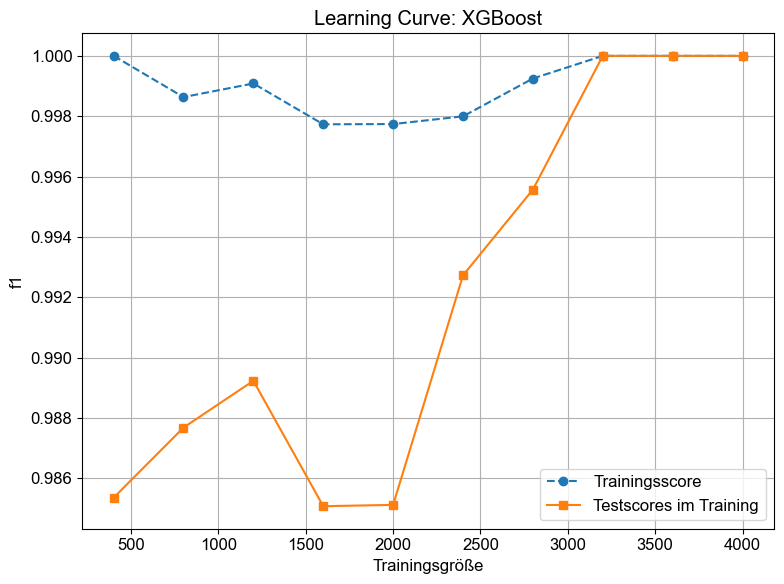

Analysiere Modell: AdaBoost...
Erstelle Validation Curve für AdaBoost...
Validation Curve gespeichert unter: results/Probenposition//new_features/AdaBoost/validation_curve_AdaBoost_clf__n_estimators.svg


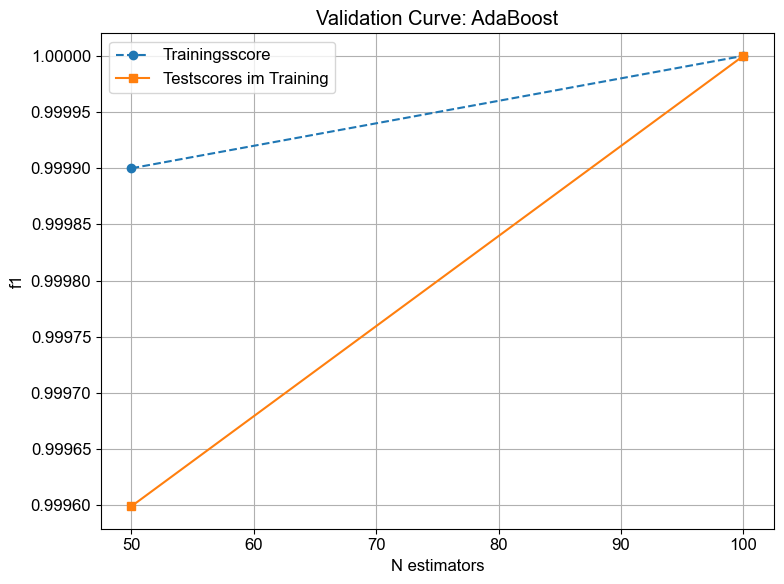

Erstelle Learning Curve für AdaBoost...
Learning Curve gespeichert unter: results/Probenposition//new_features/AdaBoost/learning_curve_AdaBoost.svg


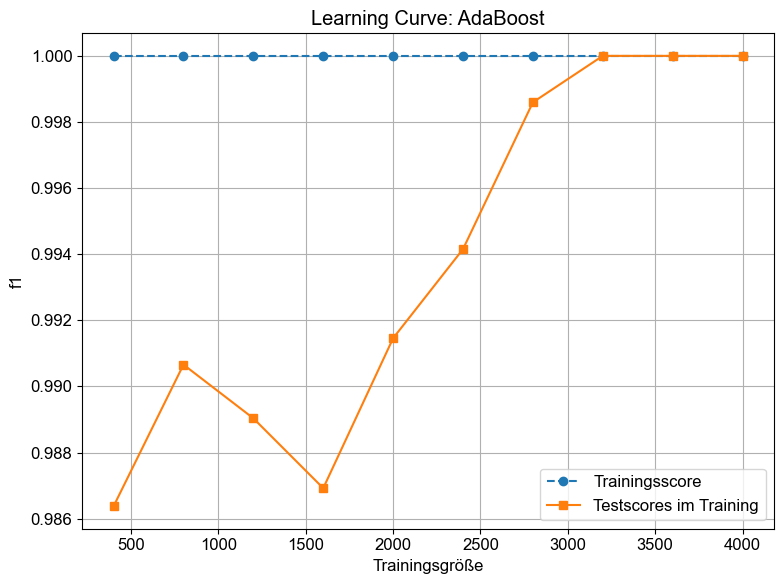

Analysiere Modell: Random Forest...
Erstelle Validation Curve für Random Forest...
Validation Curve gespeichert unter: results/Probenposition//new_features/Random Forest/validation_curve_Random Forest_clf__n_estimators.svg


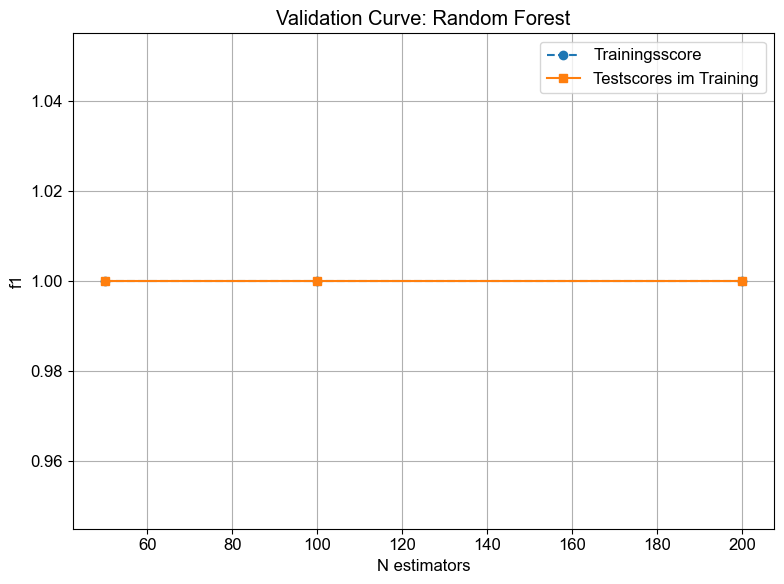

Erstelle Learning Curve für Random Forest...
Learning Curve gespeichert unter: results/Probenposition//new_features/Random Forest/learning_curve_Random Forest.svg


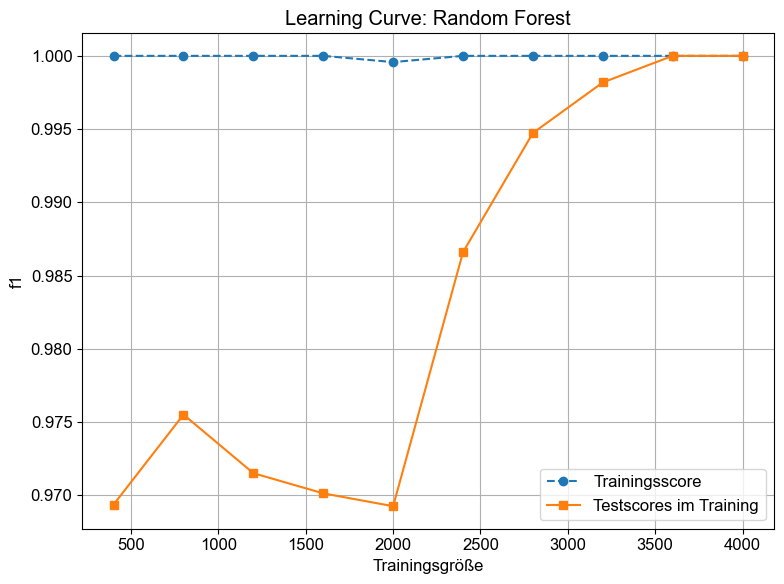

Analysiere Modell: SVM...
Erstelle Validation Curve für SVM...
Validation Curve gespeichert unter: results/Probenposition//new_features/SVM/validation_curve_SVM_clf__C.svg


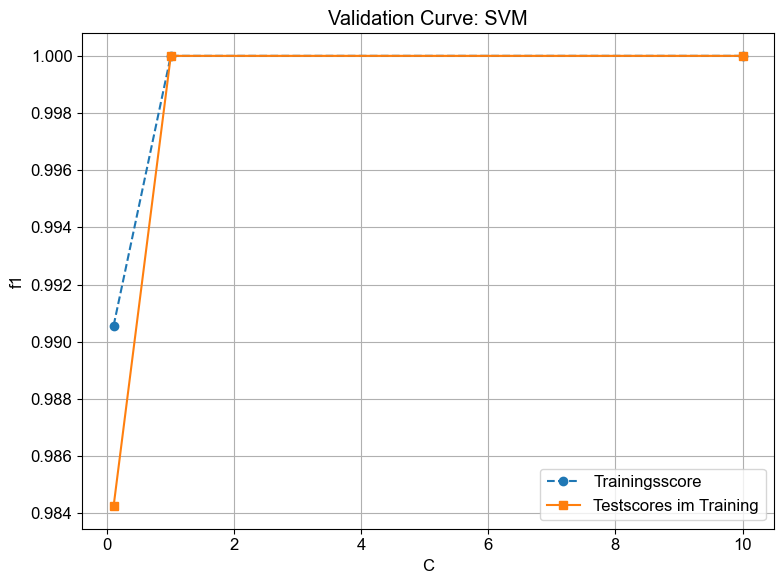

Erstelle Learning Curve für SVM...
Learning Curve gespeichert unter: results/Probenposition//new_features/SVM/learning_curve_SVM.svg


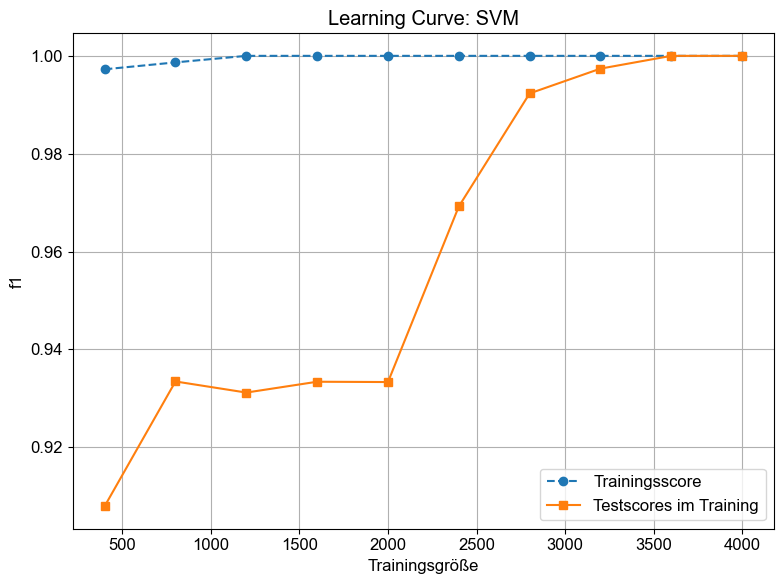

Analysiere Modell: kNN...
Erstelle Validation Curve für kNN...
Validation Curve gespeichert unter: results/Probenposition//new_features/kNN/validation_curve_kNN_clf__n_neighbors.svg


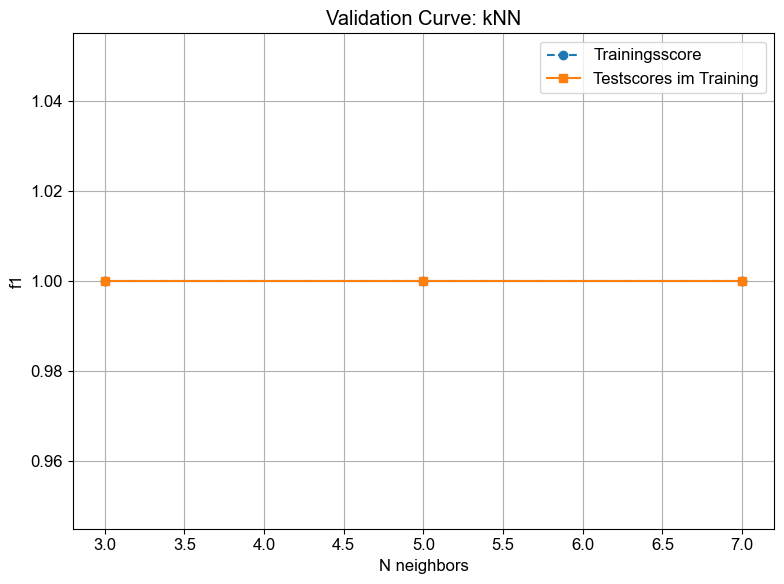

Erstelle Learning Curve für kNN...
Learning Curve gespeichert unter: results/Probenposition//new_features/kNN/learning_curve_kNN.svg


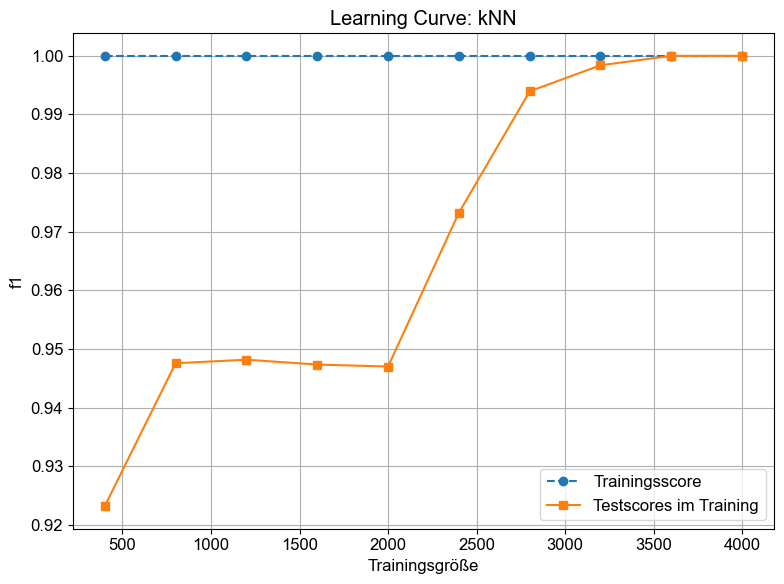

Analysiere Modell: Logistische Regression...
Erstelle Validation Curve für Logistische Regression...
Validation Curve gespeichert unter: results/Probenposition//new_features/Logistische Regression/validation_curve_Logistische Regression_clf__C.svg


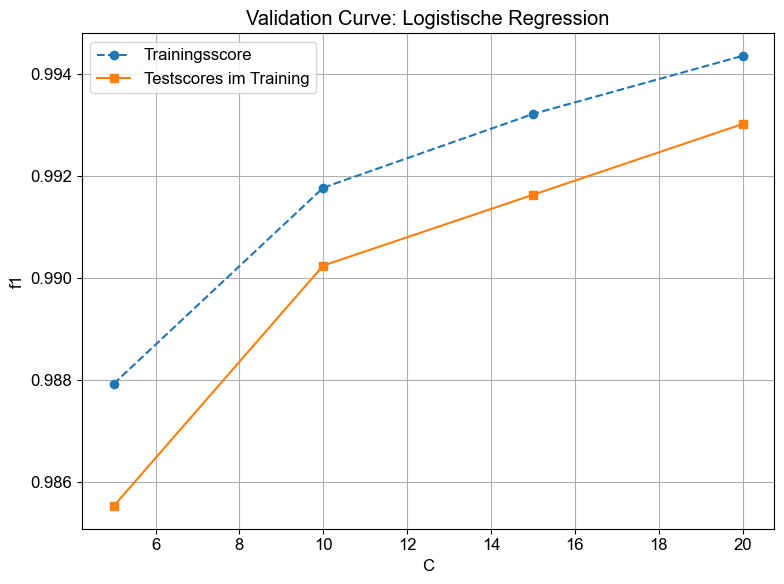

Erstelle Learning Curve für Logistische Regression...


/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Learning Curve gespeichert unter: results/Probenposition//new_features/Logistische Regression/learning_curve_Logistische Regression.svg


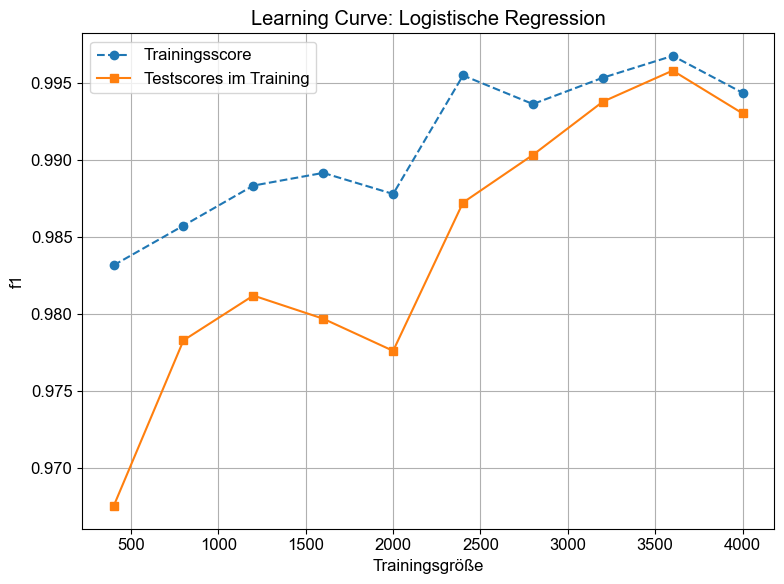

In [ ]:
# Analyse von Learning Curves für Bias-Variance-Tradeoff
print(f"\nLearning Curve Analyse für {target_name}:")

# Analyse der Modellleistung
analyze_model_performance(
    pipelines=pipelines, 
    param_grids=param_grids, 
    X=X_train, 
    y=y_train, 
    scoring='f1', 
    cv=skf,
    save_plots=save_plots,
    output_dir= target_dir,
    Verkippung=Verkippung
)

## SHAP-Analyse

In [ ]:
# SHAP-Analyse
if shap_on:
    shap_analysis(
    best_pipelines=best_pipelines,  # Das Dictionary der besten Pipelines
    X_train=X_train,  # Die Trainingsdaten
    target_name = target_name,  # Der Zielname, z. B. für das Modellieren des Zielwerts
    dataset_name= dataset_name,  # Der Name des Datensets
    output_dir= target_dir,  # Optional: Basisverzeichnis für die Ergebnisse
    plot_type=plot_type,
    save_plots=save_plots,  # Angabe, ob die Diagramme gespeichert werden sollen
    verkippung = Verkippung
)



In [ ]:
# Alle Diagramme aus der Zielgröße laden
display_top_models_for_target(
    target_dir,
    results_df_3,
    metric,
    verkippung=Verkippung,
    top_n=3  # Nur die besten 3 Modelle anzeigen
)


Top-3 Modelle basierend auf der Metrik 'f1_weighted':
XGBoost                    0.96781
Logistische Regression    0.951715
AdaBoost                  0.951613
Name: f1_weighted, dtype: object

Top-3 Modelle basierend auf der gewichteten Metrik 'f1_weighted':
XGBoost                    0.96781
Logistische Regression    0.951715
AdaBoost                  0.951613
Name: f1_weighted, dtype: object

Top-3 Modelle basierend auf der gewichteten Metrik 'percent_diff_f1_weighted':
kNN              24.104297
SVM              18.955469
Random Forest     8.939679
Name: percent_diff_f1_weighted, dtype: object

Anzeigen der SHAP-Diagramme für Modelle in den Top-3 (zusammengefasst): Random Forest, Logistische Regression, XGBoost, kNN, SVM, AdaBoost
SHAP-Diagramm für Random Forest nicht gefunden unter results/Probenposition//new_features/Random Forest/shap_summary_Random Forest.svg.
SHAP-Diagramm für Logistische Regression nicht gefunden unter results/Probenposition//new_features/Logistische Regressi

# Vergleich der Results 


In [ ]:
results_dfs = {
    "Process Features": results_df_1,
    "Aggregated Features": results_df_2,
    "New Features": results_df_3
}

# Vergleich der Ergebnisse über die Datasets hinweg
compare_metric = "f1_weighted"
comparison_table, best_combination = compare_results_across_datasets(results_dfs, metric="f1")

# Vergleichstabelle in HTML-Format konvertieren und anzeigen
print(f"Vergleich der {compare_metric}-Scores für die unterschiedlichen Datasets und Modelle:")
display(HTML(comparison_table.to_html()))

# Beste Kombination ausgeben
print(f"\nBeste Kombination:")
print(f"Dataset: {best_combination[0]}, Modell: {best_combination[1]}, Score: {best_combination[2]:.4f}")

save_scores_to_csv(
    results=comparison_table,
    output_dir=target_dir,
    file_name=f"compare_model_scores_{target_name}_{compare_metric}.csv",
    Verkippung=Verkippung
)

Vergleich der f1_weighted-Scores für die unterschiedlichen Datasets und Modelle:


Dataset,Process Features,Aggregated Features,New Features
Model,,,
XGBoost,0.653465,0.767677,0.962963
AdaBoost,0.647059,0.752475,0.943396
Logistische Regression,0.596491,0.943396,0.944444
Random Forest,0.594059,0.687500,0.891089
SVM,0.565657,0.589474,0.757895
kNN,0.509804,0.640000,0.727273



Beste Kombination:
Dataset: New Features, Modell: XGBoost, Score: 0.9630
Scores erfolgreich gespeichert unter: results/Probenposition//new_features/compare_model_scores_Probenposition_f1_weighted.csv


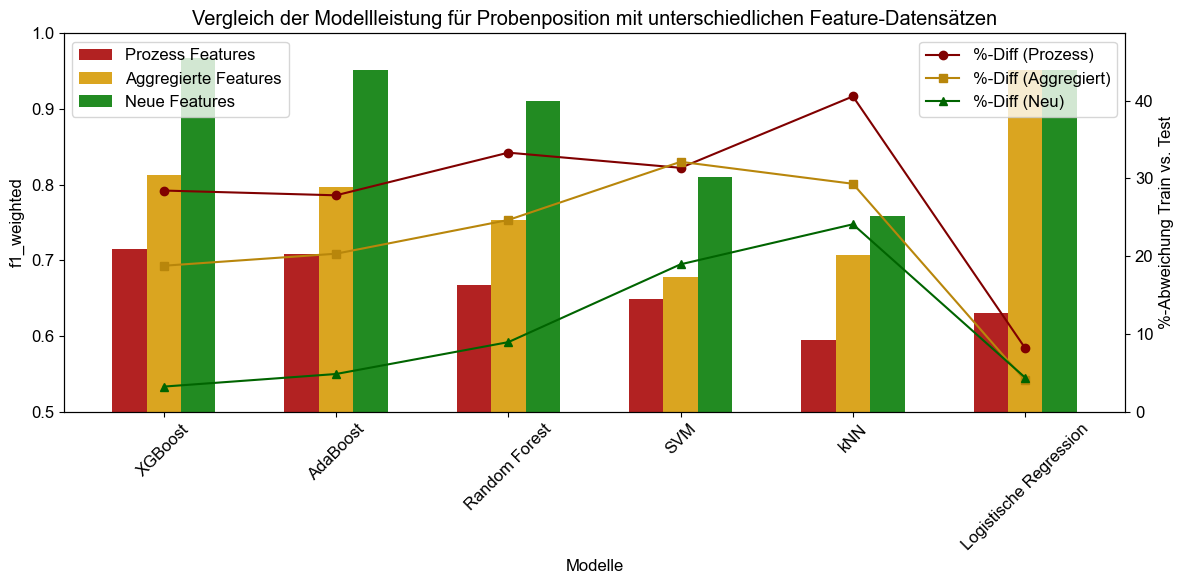

In [ ]:
output_path = f"./results/{target_name}/{balance_suffix}{tilt_suffix}{temp_suffix}/compare_model_scores_{target_name}_{compare_metric}{balance_suffix}{tilt_suffix}{temp_suffix}.svg"

# Diagramm erstellen
plot_scores_and_percent_diff(results_dfs, target_name=target_name, output_path=output_path, y_lim=(0.5, 1.0), metric=metric)

# Reduktion der Features und Performance des Best Models

In [29]:
# Modell und Feature Datensatz auswählen
model_name = "Logistische Regression"
pipeline = best_pipelines[model_name]
dataset_name = "new_features"

target_dir, feature_importance_path, balance_suffix, feature_importance_path_best, target_dir_best, tilt_suffix, temp_suffix  = direcetion_results(dataset_name, target_name, smote_on, Verkippung, bauteil_temp, model_name=model_name)

# Verzeichnis erstellen, falls es nicht existiert
os.makedirs(target_dir, exist_ok=True)

In [30]:
# SHAP-Analyse für ein einzelnes Modell
# shap_analysis_single_model(
#     model_name=model_name,
#     pipeline=pipeline,
#     X_train=X_train,
#     target_name=target_name,
#     dataset_name=dataset_name,
#     output_dir=target_dir_best,
#     plot_type=plot_type,
#     save_plots=save_plots,
#     verkippung=Verkippung
# )

Feature-Wichtigkeiten aus results/best_models//Probenposition//feature_importance_Logistische Regression.csv geladen.
Originale Trainingsdaten: (5000, 70), Testdaten: (124, 70)
Reduzierte Trainingsdaten nach SHAP: (5000, 12), Testdaten: (124, 12)
Reduzierte Trainingsdaten nach Korrelationsanalyse: (5000, 5), Testdaten: (124, 5)
Reduzierte Trainingsdaten nach VIF-Analyse: (5000, 1), Testdaten: (124, 1)

Entfernte hoch korrelierte Features: {'Verkippung_2_Median', 'Verkippung_3_Max', 'Verkippung_1_Max', 'Verkippung_4_Max', 'Verkippung_3_Mean', 'Verkippung_4_Mean', 'Verkippung_1_Mean'}

Entfernte Features wegen hohem VIF (> {vif_threshold}): {'Verkippung_3_Median', 'Verkippung_2_Max', 'Verkippung_1_Std', 'Verkippung_2_Mean'}

Korrelierte Feature-Paare (Korrelation > {correlation_threshold}):
Verkippung_3_Mean <--> Verkippung_2_Mean (Korrelation: 0.99)
Verkippung_1_Mean <--> Verkippung_2_Mean (Korrelation: 0.99)
Verkippung_4_Mean <--> Verkippung_2_Mean (Korrelation: 0.99)
Verkippung_2_Mean

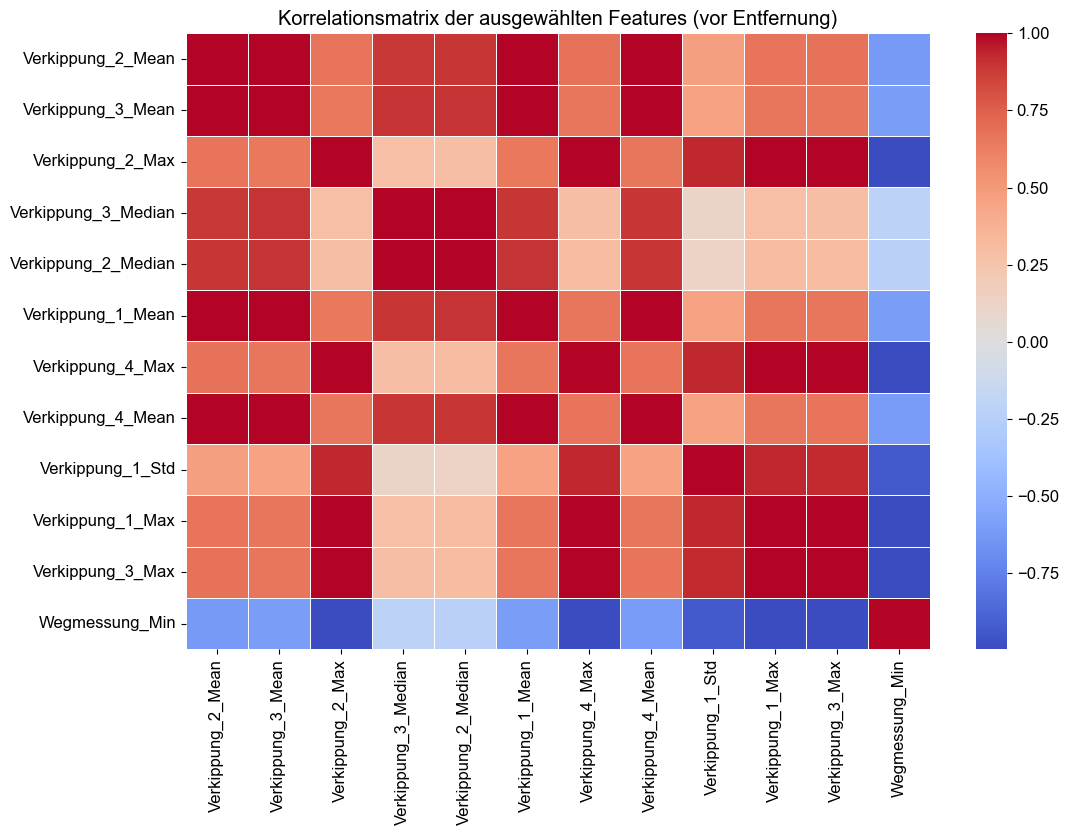

VIF-Plot gespeichert unter: results/best_models/Probenposition/vif_plot_Probenposition.svg


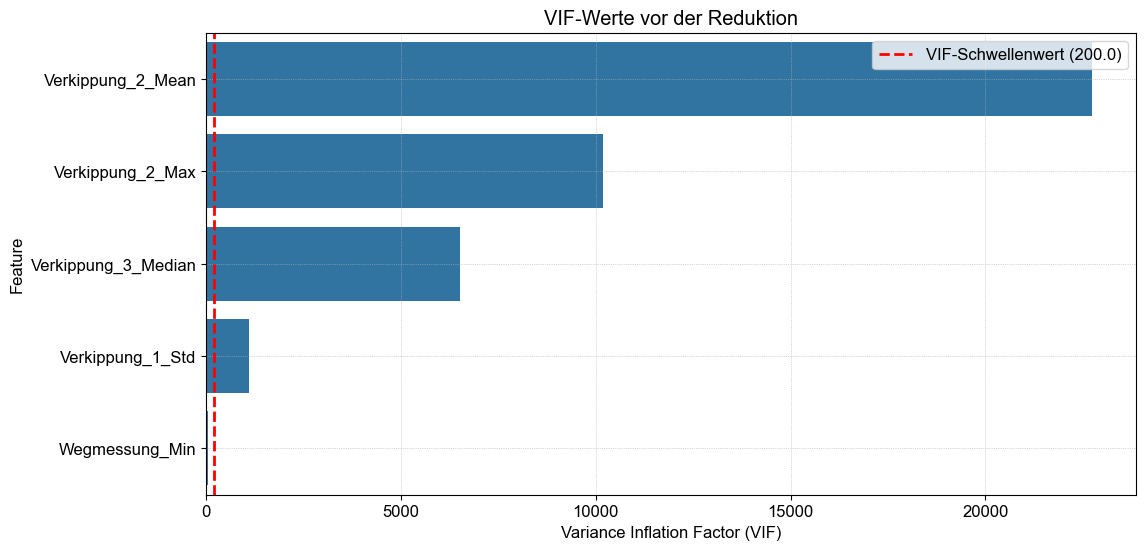

Feature-Werte gespeichert unter: results/best_models/Probenposition/selected_features_Probenposition.csv
Korrelierte Feature-Paare gespeichert unter: results/best_models/Probenposition/correlated_feature_pairs_Probenposition.csv
VIF-Werte vor der Reduktion gespeichert unter: results/best_models/Probenposition/vif_before_reduction_Probenposition.csv
Training Logistische Regression...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/py

Berechnung der finalen Scores für Logistische Regression...
Training Logistische Regression...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/py

Berechnung der finalen Scores für Logistische Regression...


/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Confusion-Matrix für Logistische Regression (Testdaten):
Confusion-Matrix für Logistische Regression gespeichert unter: results/best_models/Probenposition/Logistische Regression/final_confusion_matrix.svg


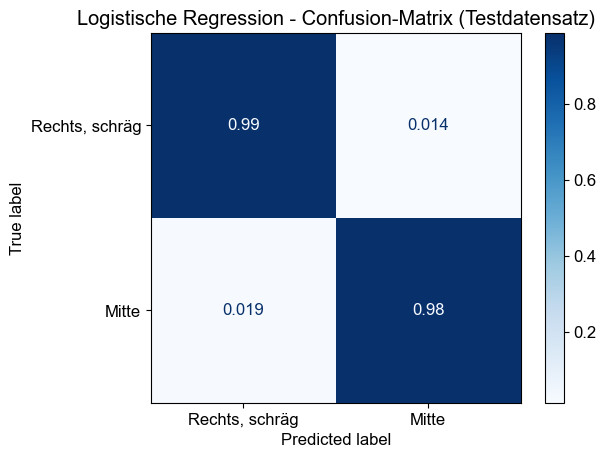

Modell für Probenposition gespeichert unter: results/best_models/Probenposition/ProbenpositionModel.pkl
Feature-Namen gespeichert unter: results/best_models/Probenposition/ProbenpositionModel_features.txt
Scores erfolgreich gespeichert unter: results/best_models/Probenposition/model_scores_best_model_Probenposition.csv
Training Logistische Regression...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda310/lib/py

Berechnung der finalen Scores für Logistische Regression...
Training Logistische Regression...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Berechnung der finalen Scores für Logistische Regression...
Ergebnistabelle gespeichert unter: results/best_models/Probenposition/summary_feature_selection_Probenposition.csv


In [31]:
# **AUFRUF DER FUNKTION**
best_pipelines, retrain_results = filter_and_retrain_with_vif(
    model_name=model_name,
    pipeline=pipeline,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    feature_importance_path=feature_importance_path_best,
    param_grids=param_grids,
    cv=skf,
    scoring=metric,
    pareto_split=0.8,  
    correlation_threshold=0.9,  
    vif_threshold=200.0,  
    output_dir=target_dir_best,
    target_name=target_name,
    dataset_name=dataset_name,
    verkippung=Verkippung,
    is_regression=False ,
    label_mapping_path=label_mapping_path,    # Neuer Parameter für Confusion-Matrix
    target_column=target_column          # Neuer Parameter für Confusion-Matri
)

# Visualisierung der Ergebnisse


## SMOTE für Prozess Features


Plot gespeichert unter: ./results/Probenposition/compare_SMOTE_process_features_Probenposition_f1_weighted.svg


<Figure size 1000x600 with 0 Axes>

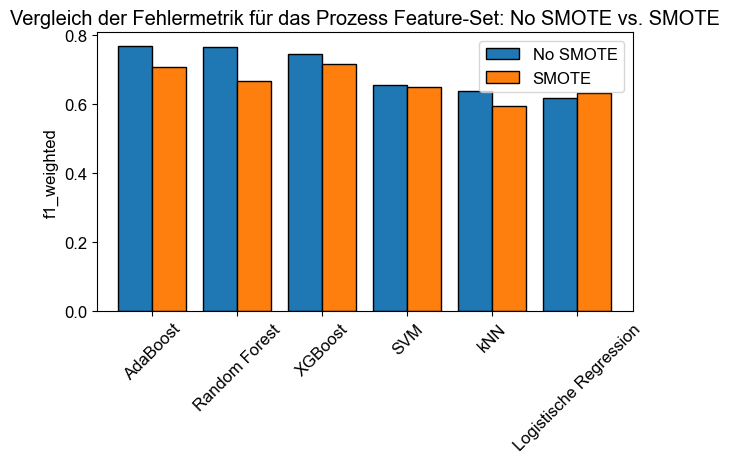

In [ ]:
smote_path = f"./results/{target_name}/{tilt_suffix}{temp_suffix}/process_features/model_scores_process_features.csv"
no_smote_path = f"./results/{target_name}/noSMOTE{tilt_suffix}{temp_suffix}/process_features/model_scores_process_featuresnoSMOTE.csv"
output_path = f"./results/{target_name}/compare_SMOTE_process_features_{target_name}_{compare_metric}.svg"
df_comp = compare_smote_effects(no_smote_path, smote_path, metric=metric, title=f"Vergleich der Fehlermetrik für das Prozess Feature-Set: No SMOTE vs. SMOTE", save_path=output_path)
 
